# Podpunkt 0: Ustalenie długości danych N oraz innych parametrów symulacji


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
from scipy.stats import t
import random

In [ ]:
# Parametry do analizy
N_values = [50, 100, 1000]
phi_values = [-0.9, -0.3, 0, 0.3, 0.9]
df_values = [3, 5, 8]

# stałe parametry do symulacji
phi_value = 0.6  # przykładowa wartość parametru dla AR(1)
df_value = 5     # stopnie swobody dla rozkładu t-Studenta
N_value = 1000

# Generowanie danych z modelu AR(1) ze składnikami losowymi z rozkładu t-Studenta


In [ ]:
# Funkcja generująca proces AR(1) ze składnikami losowymi o rozkładzie t-Studenta
def generate_ar1_t_errors(N, phi, df):
    errors = t.rvs(df, size=N)
    y = np.zeros(N)
    for time in range(1, N):
        y[time] = phi * y[time-1] + errors[time]
    return y


## 📌Analizowanie wpływu zmiany parametru N

### Stała liczba stopnii swobody 5, zmienne phi


📌 duże dodatnie wartości phi, stała liczba stopnii swobody

In [ ]:
phi_value = 0.9
df_value = 5


# Symulacja dla różnych długości danych N
results_N = []
for sim in range(1000):
    for N in N_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N, phi_value, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_N.append({
            'N': N,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_N = pd.DataFrame(results_N)

# Obliczanie średnich wartości z symulacji dla każdej wartości N
mean_results_N = df_results_N.groupby('N', as_index=False).mean()

# Wyświetlenie tabeli wyników
print("Tabela wyników phi 0.9, df 5:")
print(mean_results_N)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Tabela wyników phi 0.9, df 5:
      N  estimated_phi  stderr_phi  resid_acf1
0    50       0.802021    0.093875    0.049659
1   100       0.850335    0.055907    0.028200
2  1000       0.895283    0.014281    0.002932


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności
# Pobranie wartości oszacowań phi z symulacji
phi_values = df_results_N['estimated_phi'].values
mean_phi = np.mean(phi_values)
std_phi = np.std(phi_values)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (zakładamy, że true_phi = phi_value)
true_phi = phi_value
t_stat_unbiased = (mean_phi - true_phi) / (std_phi / np.sqrt(len(phi_values)))
p_value_unbiased = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased)))

# Obliczenie rozkładu statystyk testowych i odsetka odrzuceń hipotezy H0: phi = true_phi
significance_level = 0.05
reject_null_hypothesis = np.abs((phi_values - true_phi) / std_phi) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate = np.mean(reject_null_hypothesis) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi:")
print(f"Średnie oszacowanie phi: {mean_phi}")
print(f"Odchylenie standardowe phi: {std_phi}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic, ks_p_value = kstest(phi_values, 'norm', args=(mean_phi, std_phi))

print("\nTest normalności rozkładu estymatora phi:")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic}")
print(f"p-value testu KS: {ks_p_value}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi:
Średnie oszacowanie phi: 0.849213151047214
Odchylenie standardowe phi: 0.07516508281942987
t-statystyka dla testu nieobciążoności: -37.00801190211414
p-value dla testu nieobciążoności: 0.0
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 10.333333333333334%

Test normalności rozkładu estymatora phi:
Statystyka testu Kołmogorowa-Smirnowa: 0.16261437273792284
p-value testu KS: 8.761629065627087e-70


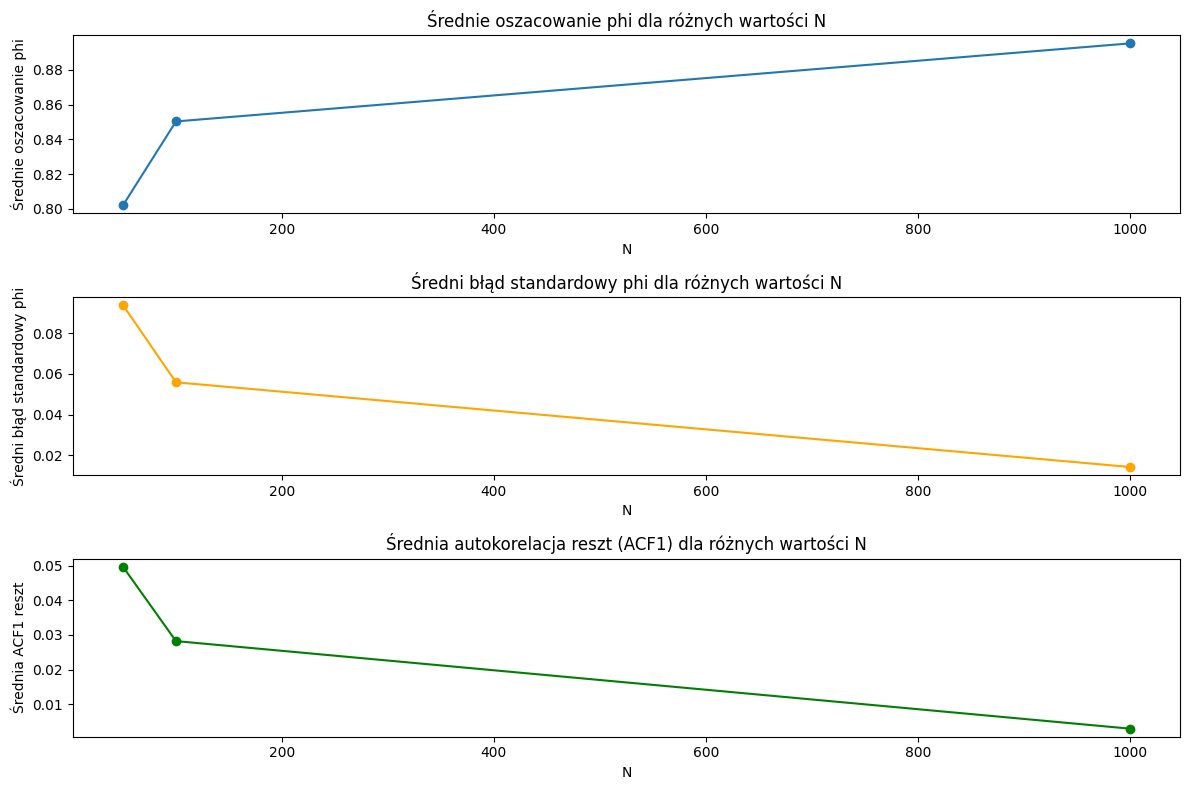

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_N['N'], mean_results_N['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_N['N'], mean_results_N['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_N['N'], mean_results_N['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()


📌 duże ujemne wartości phi, stała liczba stopnii swobody

In [ ]:
phi_value = -0.9
df_value = 5


# Symulacja dla różnych długości danych N
results_N = []
for sim in range(1000):
    for N in N_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N, phi_value, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_N.append({
            'N': N,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_N = pd.DataFrame(results_N)

# Obliczanie średnich wartości z symulacji dla każdej wartości N
mean_results_N = df_results_N.groupby('N', as_index=False).mean()

# Wyświetlenie tabeli wyników
print("Tabela wyników phi -0.9, df 5:")
print(mean_results_N)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Tabela wyników phi -0.9, df 5:
      N  estimated_phi  stderr_phi  resid_acf1
0    50      -0.849868    0.078800   -0.049472
1   100      -0.873350    0.051287   -0.028354
2  1000      -0.897161    0.014175   -0.002865


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności
# Pobranie wartości oszacowań phi z symulacji
phi_values = df_results_N['estimated_phi'].values
mean_phi = np.mean(phi_values)
std_phi = np.std(phi_values)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (zakładamy, że true_phi = phi_value)
true_phi = phi_value
t_stat_unbiased = (mean_phi - true_phi) / (std_phi / np.sqrt(len(phi_values)))
p_value_unbiased = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased)))

# Obliczenie rozkładu statystyk testowych i odsetka odrzuceń hipotezy H0: phi = true_phi
significance_level = 0.05
reject_null_hypothesis = np.abs((phi_values - true_phi) / std_phi) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate = np.mean(reject_null_hypothesis) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi:")
print(f"Średnie oszacowanie phi: {mean_phi}")
print(f"Odchylenie standardowe phi: {std_phi}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic, ks_p_value = kstest(phi_values, 'norm', args=(mean_phi, std_phi))

print("\nTest normalności rozkładu estymatora phi:")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic}")
print(f"p-value testu KS: {ks_p_value}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi:
Średnie oszacowanie phi: -0.8734600534736371
Odchylenie standardowe phi: 0.057997300772223204
t-statystyka dla testu nieobciążoności: 25.064144699699323
p-value dla testu nieobciążoności: 0.0
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 8.333333333333332%

Test normalności rozkładu estymatora phi:
Statystyka testu Kołmogorowa-Smirnowa: 0.16539417161662578
p-value testu KS: 3.4433145839118513e-72


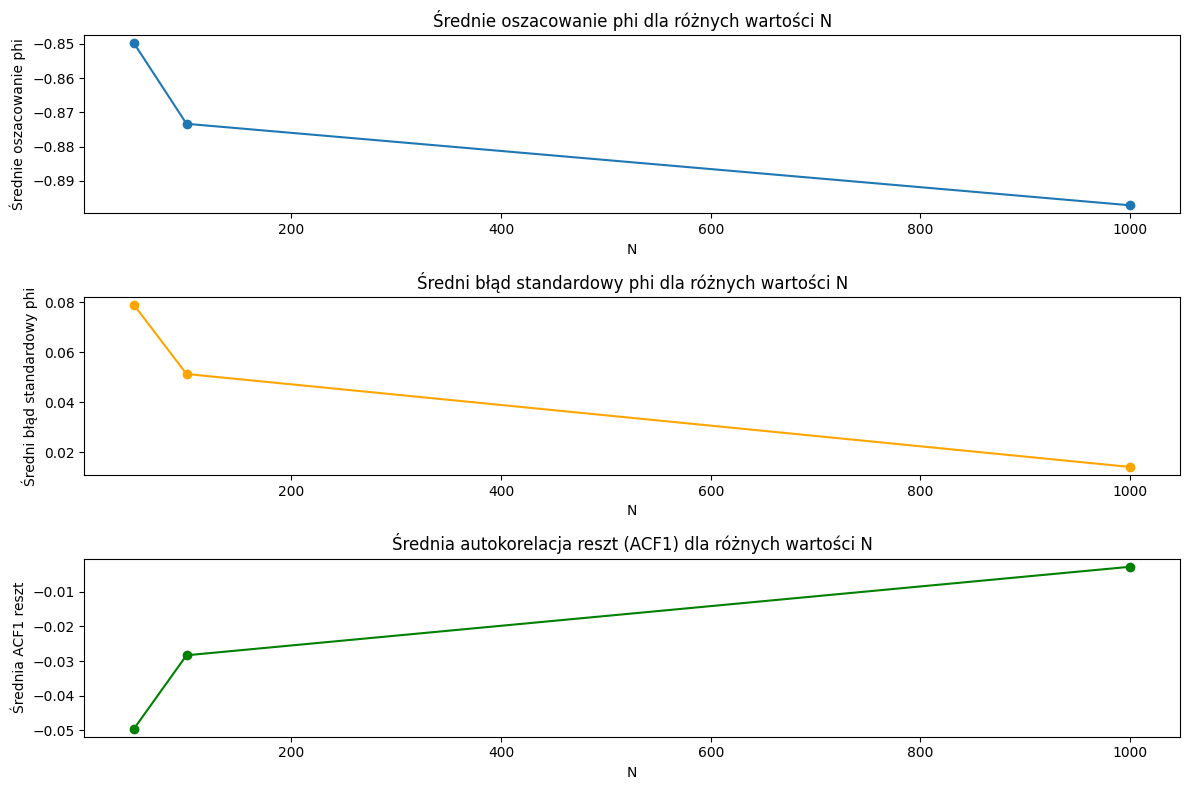

In [ ]:

# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_N['N'], mean_results_N['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_N['N'], mean_results_N['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_N['N'], mean_results_N['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()


📌 neutralna wartość phi, stała liczba stopnii swobody

In [ ]:
phi_value = 0
df_value = 5


# Symulacja dla różnych długości danych N
results_N = []
for sim in range(1000):
    for N in N_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N, phi_value, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_N.append({
            'N': N,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_N = pd.DataFrame(results_N)

# Obliczanie średnich wartości z symulacji dla każdej wartości N
mean_results_N = df_results_N.groupby('N', as_index=False).mean()

# Wyświetlenie tabeli wyników
print("Tabela wyników phi 0, df 5:")
print(mean_results_N)

Tabela wyników phi 0, df 5:
      N  estimated_phi  stderr_phi  resid_acf1
0    50      -0.013007    0.174405   -0.000870
1   100      -0.015257    0.114110   -0.000418
2  1000      -0.001608    0.032350    0.000017


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności
# Pobranie wartości oszacowań phi z symulacji
phi_values = df_results_N['estimated_phi'].values
mean_phi = np.mean(phi_values)
std_phi = np.std(phi_values)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (zakładamy, że true_phi = phi_value)
true_phi = phi_value
t_stat_unbiased = (mean_phi - true_phi) / (std_phi / np.sqrt(len(phi_values)))
p_value_unbiased = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased)))

# Obliczenie rozkładu statystyk testowych i odsetka odrzuceń hipotezy H0: phi = true_phi
significance_level = 0.05
reject_null_hypothesis = np.abs((phi_values - true_phi) / std_phi) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate = np.mean(reject_null_hypothesis) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi:")
print(f"Średnie oszacowanie phi: {mean_phi}")
print(f"Odchylenie standardowe phi: {std_phi}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic, ks_p_value = kstest(phi_values, 'norm', args=(mean_phi, std_phi))

print("\nTest normalności rozkładu estymatora phi:")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic}")
print(f"p-value testu KS: {ks_p_value}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi:
Średnie oszacowanie phi: -0.009956983614444814
Odchylenie standardowe phi: 0.10011978383816884
t-statystyka dla testu nieobciążoności: -5.447139737292996
p-value dla testu nieobciążoności: 5.118624990529952e-08
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 7.1%

Test normalności rozkładu estymatora phi:
Statystyka testu Kołmogorowa-Smirnowa: 0.07462619221548433
p-value testu KS: 5.633223250482369e-15


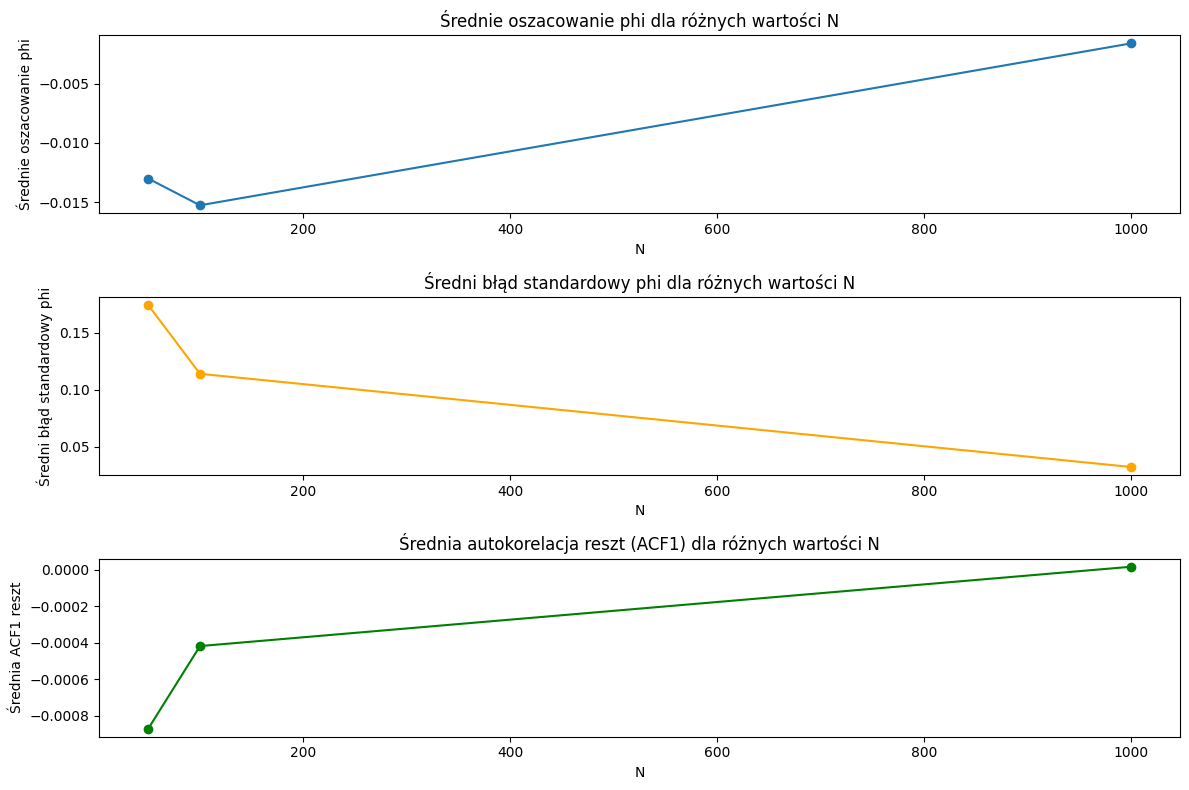

In [ ]:

# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_N['N'], mean_results_N['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_N['N'], mean_results_N['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_N['N'], mean_results_N['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()


### Stała wartość phi 0.3, zmienne stopnie swobody


📌 stała wartość phi, bardzo mała wartość stopni swobody

In [ ]:
phi_value = 0.3
df_value = 3


# Symulacja dla różnych długości danych N
results_N = []
for sim in range(1000):
    for N in N_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N, phi_value, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_N.append({
            'N': N,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_N = pd.DataFrame(results_N)

# Obliczanie średnich wartości z symulacji dla każdej wartości N
mean_results_N = df_results_N.groupby('N', as_index=False).mean()

# Wyświetlenie tabeli wyników
print("Tabela wyników phi 0, df 5:")
print(mean_results_N)

Tabela wyników phi 0, df 5:
      N  estimated_phi  stderr_phi  resid_acf1
0    50       0.256699    0.192279    0.015311
1   100       0.281359    0.122780    0.007195
2  1000       0.295979    0.033680    0.000759


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności
# Pobranie wartości oszacowań phi z symulacji
phi_values = df_results_N['estimated_phi'].values
mean_phi = np.mean(phi_values)
std_phi = np.std(phi_values)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (zakładamy, że true_phi = phi_value)
true_phi = phi_value
t_stat_unbiased = (mean_phi - true_phi) / (std_phi / np.sqrt(len(phi_values)))
p_value_unbiased = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased)))

# Obliczenie rozkładu statystyk testowych i odsetka odrzuceń hipotezy H0: phi = true_phi
significance_level = 0.05
reject_null_hypothesis = np.abs((phi_values - true_phi) / std_phi) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate = np.mean(reject_null_hypothesis) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi:")
print(f"Średnie oszacowanie phi: {mean_phi}")
print(f"Odchylenie standardowe phi: {std_phi}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic, ks_p_value = kstest(phi_values, 'norm', args=(mean_phi, std_phi))

print("\nTest normalności rozkładu estymatora phi:")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic}")
print(f"p-value testu KS: {ks_p_value}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi:
Średnie oszacowanie phi: 0.27801248972557624
Odchylenie standardowe phi: 0.09578816975518513
t-statystyka dla testu nieobciążoności: -12.572591575199805
p-value dla testu nieobciążoności: 0.0
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 7.533333333333333%

Test normalności rozkładu estymatora phi:
Statystyka testu Kołmogorowa-Smirnowa: 0.09718173379903833
p-value testu KS: 4.1031255681339034e-25


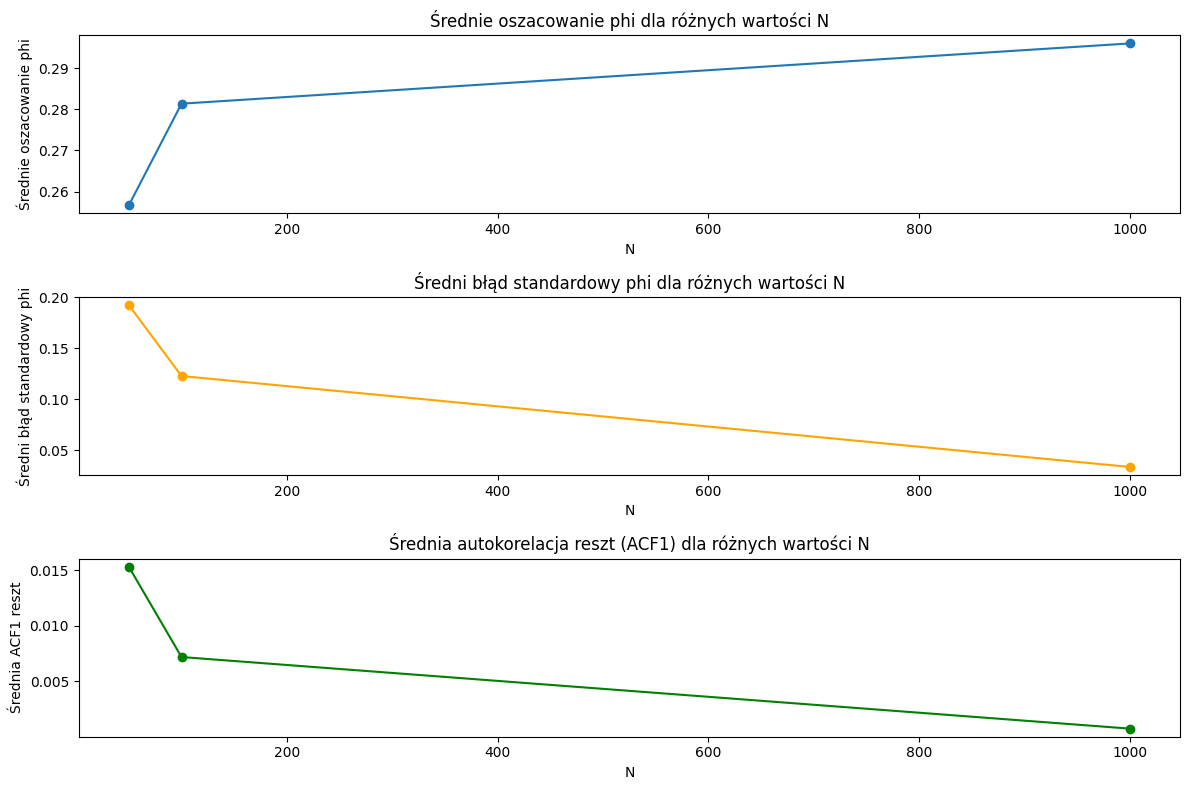

In [ ]:

# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_N['N'], mean_results_N['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_N['N'], mean_results_N['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_N['N'], mean_results_N['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()


📌 stała wartość phi, trochę większa wartość stopni swobody (nie ma sensu liczyć dla np 30 lub więcej bo wtedy mamy przybliżenie rozkładu normalnego)

In [ ]:
phi_value = 0.3
df_value = 8


# Symulacja dla różnych długości danych N
results_N = []

# Pętla główna dla różnych wartości N i powtórzeń symulacji
for sim in range(1000):
    for N in N_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N, phi_value, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_N.append({
            'N': N,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_N = pd.DataFrame(results_N)

# Obliczanie średnich wartości z symulacji dla każdej wartości N
mean_results_N = df_results_N.groupby('N', as_index=False).mean()

# Wyświetlenie tabeli wyników
print("Tabela wyników phi 0, df 5:")
print(mean_results_N)

Tabela wyników phi 0, df 5:
      N  estimated_phi  stderr_phi  resid_acf1
0    50       0.249062    0.157059    0.015521
1   100       0.278886    0.103863    0.008525
2  1000       0.297947    0.030660    0.001256


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności
# Pobranie wartości oszacowań phi z symulacji
phi_values = df_results_N['estimated_phi'].values
mean_phi = np.mean(phi_values)
std_phi = np.std(phi_values)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (zakładamy, że true_phi = phi_value)
true_phi = phi_value
t_stat_unbiased = (mean_phi - true_phi) / (std_phi / np.sqrt(len(phi_values)))
p_value_unbiased = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased)))

# Obliczenie rozkładu statystyk testowych i odsetka odrzuceń hipotezy H0: phi = true_phi
significance_level = 0.05
reject_null_hypothesis = np.abs((phi_values - true_phi) / std_phi) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate = np.mean(reject_null_hypothesis) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi:")
print(f"Średnie oszacowanie phi: {mean_phi}")
print(f"Odchylenie standardowe phi: {std_phi}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic, ks_p_value = kstest(phi_values, 'norm', args=(mean_phi, std_phi))

print("\nTest normalności rozkładu estymatora phi:")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic}")
print(f"p-value testu KS: {ks_p_value}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi:
Średnie oszacowanie phi: 0.2752982667874054
Odchylenie standardowe phi: 0.09931418903781669
t-statystyka dla testu nieobciążoności: -13.623125377241726
p-value dla testu nieobciążoności: 0.0
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 7.8%

Test normalności rozkładu estymatora phi:
Statystyka testu Kołmogorowa-Smirnowa: 0.10421655954851516
p-value testu KS: 7.99252550196239e-29


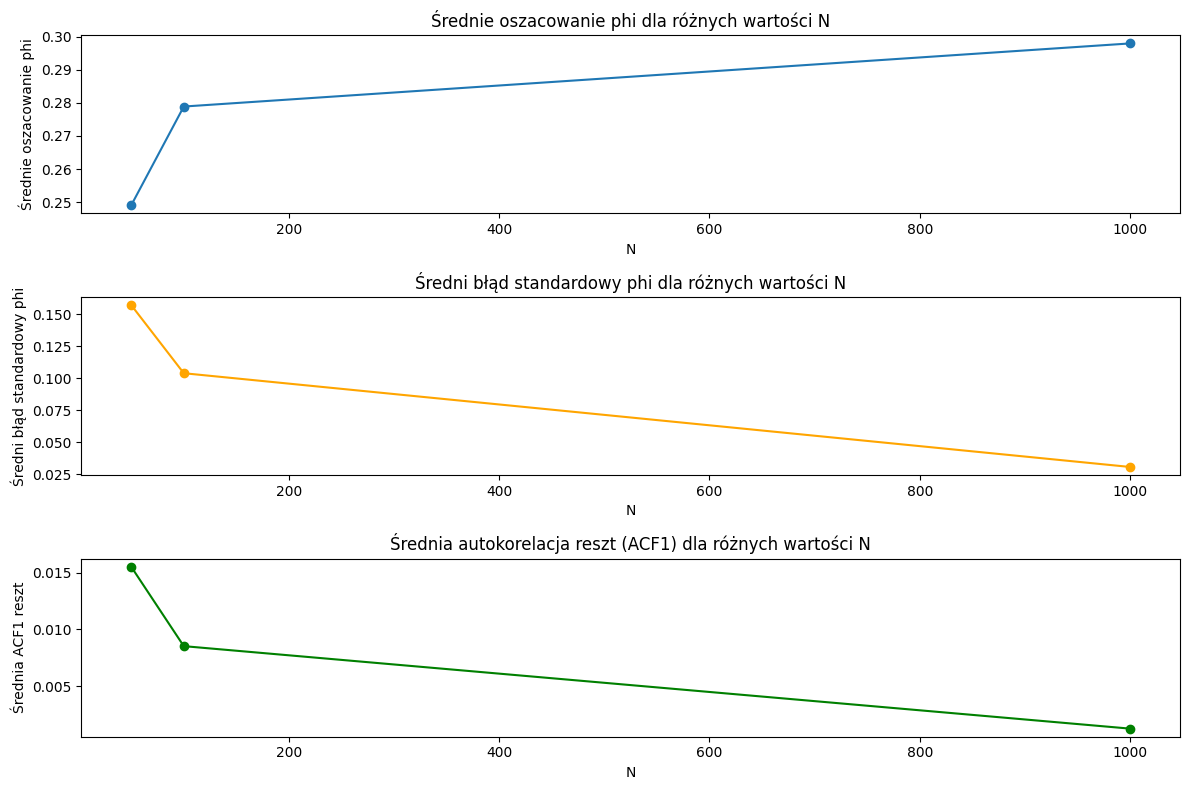

In [ ]:

# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_N['N'], mean_results_N['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_N['N'], mean_results_N['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_N['N'], mean_results_N['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości N")
plt.xlabel("N")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()


## 📌Analizowanie wpływu zmiany parametru phi

### Stałe wysokie N 1000, zmienne stopnie swobody

📌 stała wysoka wartość N, 3 st swobody

In [ ]:
N_value = 1000
df_value = 3

# Symulacja dla różnych wartości phi
results_phi = []
for sim in range(1000):
    for phi in phi_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N_value, phi, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_phi.append({
            'phi': phi,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_phi = pd.DataFrame(results_phi)

# Obliczanie średnich wartości z symulacji dla każdej wartości phi
mean_results_phi = df_results_phi.groupby('phi', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N = 1000, df = 3:")
print(mean_results_phi)

Tabela wyników, N = 1000, df = 3:
   phi  estimated_phi  stderr_phi  resid_acf1
0 -0.9      -0.897779    0.014957   -0.003139
1 -0.3      -0.301031    0.033752   -0.001168
2  0.0       0.000394    0.037369   -0.000022
3  0.3       0.298791    0.033995    0.000681
4  0.9       0.895545    0.015133    0.003159


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości phi
# Pobranie wartości oszacowań phi z symulacji
phi_values_est = df_results_phi['estimated_phi'].values
mean_phi_est = np.mean(phi_values_est)
std_phi_est = np.std(phi_values_est)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla każdej wartości phi z phi_values)
true_phi = np.mean(df_results_phi['phi'])  # średnia teoretyczna phi dla grupy phi_values
t_stat_unbiased_phi = (mean_phi_est - true_phi) / (std_phi_est / np.sqrt(len(phi_values_est)))
p_value_unbiased_phi = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_phi)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
significance_level = 0.05
reject_null_phi = np.abs((phi_values_est - true_phi) / std_phi_est) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_phi = np.mean(reject_null_phi) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):")
print(f"Średnie oszacowanie phi: {mean_phi_est}")
print(f"Odchylenie standardowe phi: {std_phi_est}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_phi}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_phi}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_phi}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_phi, ks_p_value_phi = kstest(phi_values_est, 'norm', args=(mean_phi_est, std_phi_est))

print("\nTest normalności rozkładu estymatora phi (różne phi):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_phi}")
print(f"p-value testu KS: {ks_p_value_phi}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):
Średnie oszacowanie phi: -0.0008160929392732214
Odchylenie standardowe phi: 0.5985029321493767
t-statystyka dla testu nieobciążoności: -0.09641804917582714
p-value dla testu nieobciążoności: 0.9231885577381778
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 0.0%

Test normalności rozkładu estymatora phi (różne phi):
Statystyka testu Kołmogorowa-Smirnowa: 0.12406884089470271
p-value testu KS: 1.5348679895035883e-67


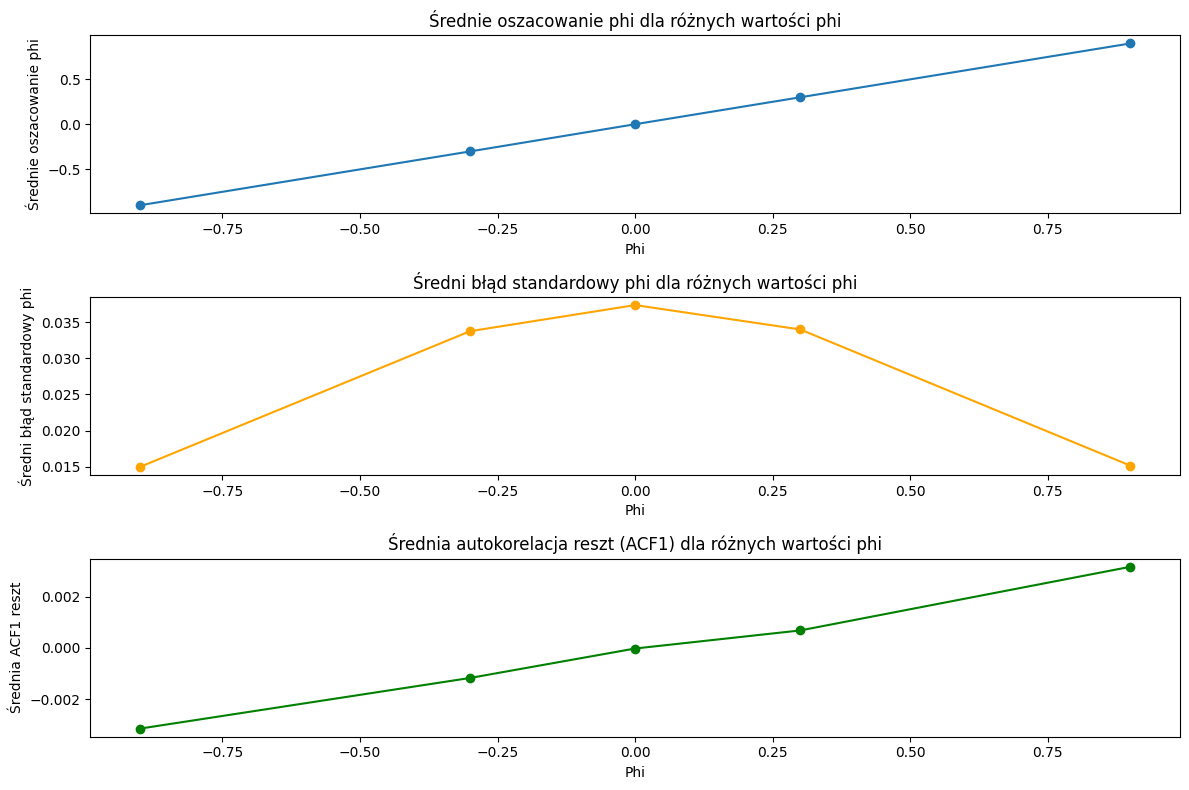

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_phi['phi'], mean_results_phi['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_phi['phi'], mean_results_phi['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_phi['phi'], mean_results_phi['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

📌 stała wysoka wartość N, 5 st swobody

In [ ]:
N_value = 1000
df_value = 5

# Symulacja dla różnych wartości phi
results_phi = []
for sim in range(1000):
    for phi in phi_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N_value, phi, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_phi.append({
            'phi': phi,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_phi = pd.DataFrame(results_phi)

# Obliczanie średnich wartości z symulacji dla każdej wartości phi
mean_results_phi = df_results_phi.groupby('phi', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N = 1000, df = 5:")
print(mean_results_phi)

Tabela wyników, N = 1000, df = 5:
   phi  estimated_phi  stderr_phi  resid_acf1
0 -0.9      -0.897849    0.014129   -0.003283
1 -0.3      -0.299954    0.030941   -0.000919
2  0.0      -0.001811    0.032511    0.000061
3  0.3       0.296363    0.031009    0.001464
4  0.9       0.895272    0.014351    0.003269


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości phi
# Pobranie wartości oszacowań phi z symulacji
phi_values_est = df_results_phi['estimated_phi'].values
mean_phi_est = np.mean(phi_values_est)
std_phi_est = np.std(phi_values_est)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla każdej wartości phi z phi_values)
true_phi = np.mean(df_results_phi['phi'])  # średnia teoretyczna phi dla grupy phi_values
t_stat_unbiased_phi = (mean_phi_est - true_phi) / (std_phi_est / np.sqrt(len(phi_values_est)))
p_value_unbiased_phi = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_phi)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
significance_level = 0.05
reject_null_phi = np.abs((phi_values_est - true_phi) / std_phi_est) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_phi = np.mean(reject_null_phi) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):")
print(f"Średnie oszacowanie phi: {mean_phi_est}")
print(f"Odchylenie standardowe phi: {std_phi_est}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_phi}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_phi}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_phi}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_phi, ks_p_value_phi = kstest(phi_values_est, 'norm', args=(mean_phi_est, std_phi_est))

print("\nTest normalności rozkładu estymatora phi (różne phi):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_phi}")
print(f"p-value testu KS: {ks_p_value_phi}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):
Średnie oszacowanie phi: -0.0015957203703691981
Odchylenie standardowe phi: 0.5981142651945138
t-statystyka dla testu nieobciążoności: -0.18865035670042338
p-value dla testu nieobciążoności: 0.8503668624292704
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 0.0%

Test normalności rozkładu estymatora phi (różne phi):
Statystyka testu Kołmogorowa-Smirnowa: 0.1240292504154888
p-value testu KS: 1.6944701431710875e-67


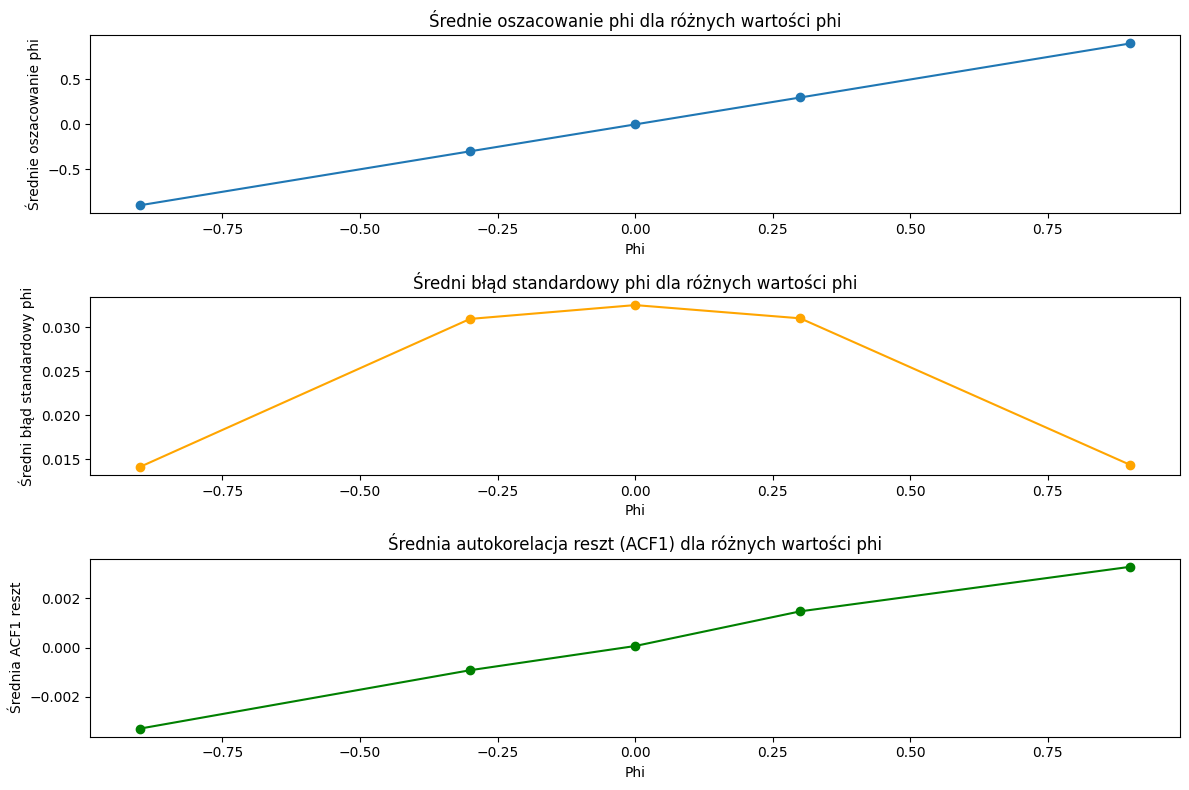

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_phi['phi'], mean_results_phi['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_phi['phi'], mean_results_phi['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_phi['phi'], mean_results_phi['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

📌 stała wysoka wartość N, 8 st swobody

In [ ]:
N_value = 1000
df_value = 8

# Symulacja dla różnych wartości phi
results_phi = []
for sim in range(1000):
    for phi in phi_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N_value, phi, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_phi.append({
            'phi': phi,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_phi = pd.DataFrame(results_phi)

# Obliczanie średnich wartości z symulacji dla każdej wartości phi
mean_results_phi = df_results_phi.groupby('phi', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N = 1000, df = 8:")
print(mean_results_phi)

Tabela wyników, N = 1000, df = 8:
   phi  estimated_phi  stderr_phi    resid_acf1
0 -0.9      -0.897495    0.014002 -2.498109e-03
1 -0.3      -0.300289    0.030534 -1.785137e-03
2  0.0      -0.001492    0.031947  5.419166e-07
3  0.3       0.298300    0.030574  1.148991e-03
4  0.9       0.895357    0.014183  2.227566e-03


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości phi
# Pobranie wartości oszacowań phi z symulacji
phi_values_est = df_results_phi['estimated_phi'].values
mean_phi_est = np.mean(phi_values_est)
std_phi_est = np.std(phi_values_est)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla każdej wartości phi z phi_values)
true_phi = np.mean(df_results_phi['phi'])  # średnia teoretyczna phi dla grupy phi_values
t_stat_unbiased_phi = (mean_phi_est - true_phi) / (std_phi_est / np.sqrt(len(phi_values_est)))
p_value_unbiased_phi = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_phi)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
significance_level = 0.05
reject_null_phi = np.abs((phi_values_est - true_phi) / std_phi_est) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_phi = np.mean(reject_null_phi) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):")
print(f"Średnie oszacowanie phi: {mean_phi_est}")
print(f"Odchylenie standardowe phi: {std_phi_est}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_phi}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_phi}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_phi}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_phi, ks_p_value_phi = kstest(phi_values_est, 'norm', args=(mean_phi_est, std_phi_est))

print("\nTest normalności rozkładu estymatora phi (różne phi):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_phi}")
print(f"p-value testu KS: {ks_p_value_phi}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):
Średnie oszacowanie phi: -0.0011236646061710172
Odchylenie standardowe phi: 0.5982674163282997
t-statystyka dla testu nieobciążoności: -0.13280864729006475
p-value dla testu nieobciążoności: 0.8943447153965935
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 0.0%

Test normalności rozkładu estymatora phi (różne phi):
Statystyka testu Kołmogorowa-Smirnowa: 0.12326256736052246
p-value testu KS: 1.1436269725958742e-66


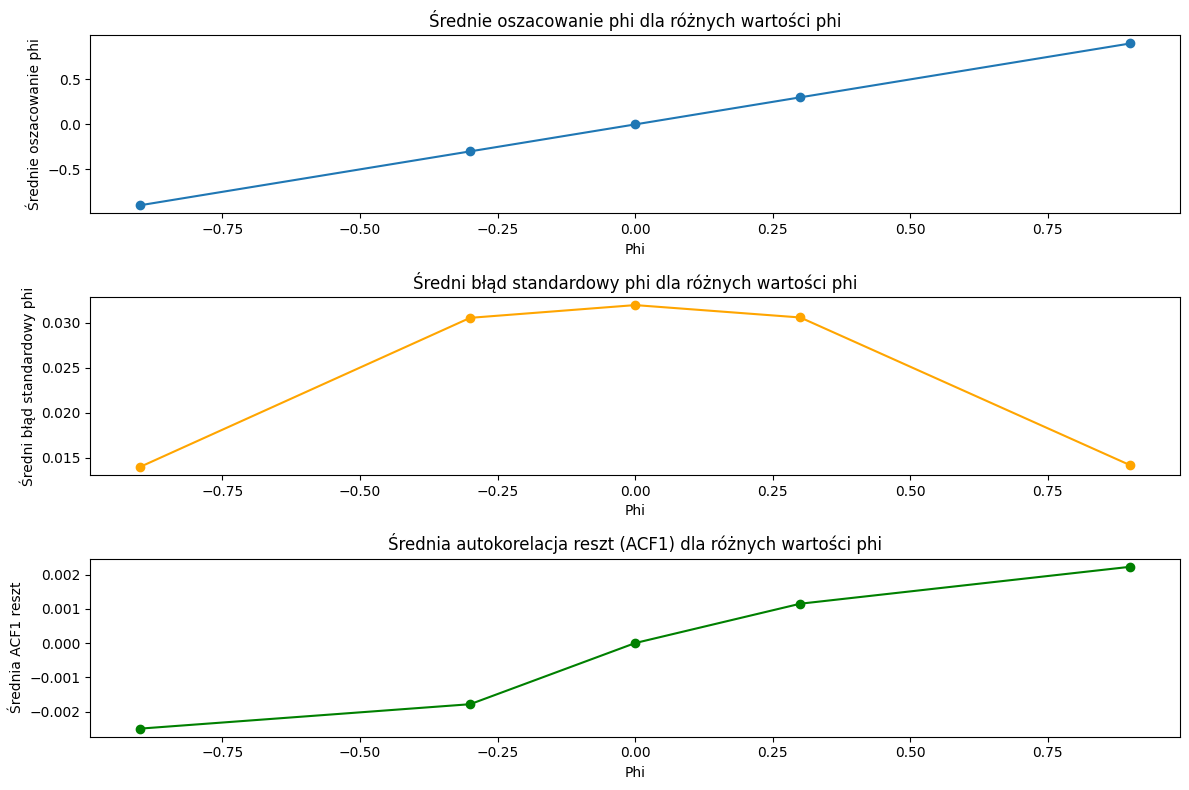

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_phi['phi'], mean_results_phi['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_phi['phi'], mean_results_phi['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_phi['phi'], mean_results_phi['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

### Stałe niskie N 50 , zmienne stopnie swobody

📌 stała niska wartość N, 3 st swobody



In [ ]:
N_value = 50
df_value = 3

# Symulacja dla różnych wartości phi
results_phi = []
for sim in range(1000):
    for phi in phi_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N_value, phi, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_phi.append({
            'phi': phi,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_phi = pd.DataFrame(results_phi)

# Obliczanie średnich wartości z symulacji dla każdej wartości phi
mean_results_phi = df_results_phi.groupby('phi', as_index=False).mean()

# Wyświetlenie tabeli wyników
print("Tabela wyników, N = 50, df = 3:")
print(mean_results_phi)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

Tabela wyników, N = 50, df = 3:
   phi  estimated_phi  stderr_phi  resid_acf1
0 -0.9      -0.855416    0.085142   -0.048880
1 -0.3      -0.299223    0.185073   -0.014952
2  0.0      -0.018414    0.203403   -0.001182
3  0.3       0.257435    0.184935    0.015474
4  0.9       0.802646    0.100199    0.041823


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości phi
# Pobranie wartości oszacowań phi z symulacji
phi_values_est = df_results_phi['estimated_phi'].values
mean_phi_est = np.mean(phi_values_est)
std_phi_est = np.std(phi_values_est)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla każdej wartości phi z phi_values)
true_phi = np.mean(df_results_phi['phi'])  # średnia teoretyczna phi dla grupy phi_values
t_stat_unbiased_phi = (mean_phi_est - true_phi) / (std_phi_est / np.sqrt(len(phi_values_est)))
p_value_unbiased_phi = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_phi)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
significance_level = 0.05
reject_null_phi = np.abs((phi_values_est - true_phi) / std_phi_est) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_phi = np.mean(reject_null_phi) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):")
print(f"Średnie oszacowanie phi: {mean_phi_est}")
print(f"Odchylenie standardowe phi: {std_phi_est}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_phi}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_phi}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_phi}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_phi, ks_p_value_phi = kstest(phi_values_est, 'norm', args=(mean_phi_est, std_phi_est))

print("\nTest normalności rozkładu estymatora phi (różne phi):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_phi}")
print(f"p-value testu KS: {ks_p_value_phi}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):
Średnie oszacowanie phi: -0.022594469731961768
Odchylenie standardowe phi: 0.5645237386467259
t-statystyka dla testu nieobciążoności: -2.83012062576565
p-value dla testu nieobciążoności: 0.004653045743346906
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 0.0%

Test normalności rozkładu estymatora phi (różne phi):
Statystyka testu Kołmogorowa-Smirnowa: 0.08583478231859817
p-value testu KS: 1.6897846286094962e-32


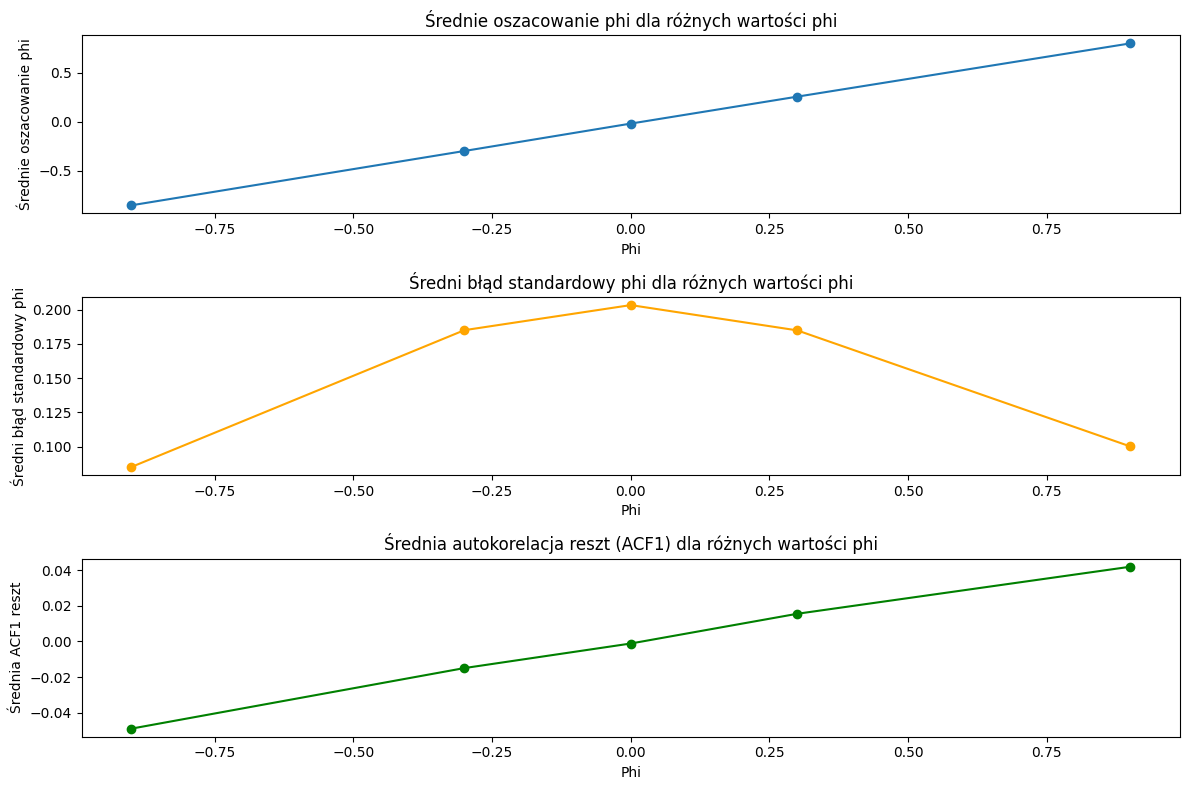

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_phi['phi'], mean_results_phi['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_phi['phi'], mean_results_phi['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_phi['phi'], mean_results_phi['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

📌 stała niska wartość N, 5 st swobody

In [ ]:
N_value = 50
df_value = 5

# Symulacja dla różnych wartości phi
results_phi = []
for sim in range(1000):
    for phi in phi_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N_value, phi, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_phi.append({
            'phi': phi,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_phi = pd.DataFrame(results_phi)

# Obliczanie średnich wartości z symulacji dla każdej wartości phi
mean_results_phi = df_results_phi.groupby('phi', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N = 50, df = 5:")
print(mean_results_phi)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

Tabela wyników, N = 50, df = 5:
   phi  estimated_phi  stderr_phi  resid_acf1
0 -0.9      -0.854120    0.077772   -0.051841
1 -0.3      -0.292788    0.163270   -0.016186
2  0.0      -0.023815    0.172014   -0.001472
3  0.3       0.253814    0.162630    0.014093
4  0.9       0.801491    0.092542    0.039481


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości phi
# Pobranie wartości oszacowań phi z symulacji
phi_values_est = df_results_phi['estimated_phi'].values
mean_phi_est = np.mean(phi_values_est)
std_phi_est = np.std(phi_values_est)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla każdej wartości phi z phi_values)
true_phi = np.mean(df_results_phi['phi'])  # średnia teoretyczna phi dla grupy phi_values
t_stat_unbiased_phi = (mean_phi_est - true_phi) / (std_phi_est / np.sqrt(len(phi_values_est)))
p_value_unbiased_phi = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_phi)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
significance_level = 0.05
reject_null_phi = np.abs((phi_values_est - true_phi) / std_phi_est) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_phi = np.mean(reject_null_phi) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):")
print(f"Średnie oszacowanie phi: {mean_phi_est}")
print(f"Odchylenie standardowe phi: {std_phi_est}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_phi}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_phi}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_phi}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_phi, ks_p_value_phi = kstest(phi_values_est, 'norm', args=(mean_phi_est, std_phi_est))

print("\nTest normalności rozkładu estymatora phi (różne phi):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_phi}")
print(f"p-value testu KS: {ks_p_value_phi}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):
Średnie oszacowanie phi: -0.0230836355881562
Odchylenie standardowe phi: 0.564090654414174
t-statystyka dla testu nieobciążoności: -2.893612069459987
p-value dla testu nieobciążoności: 0.0038083835747768635
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 0.0%

Test normalności rozkładu estymatora phi (różne phi):
Statystyka testu Kołmogorowa-Smirnowa: 0.08103164082798989
p-value testu KS: 5.256665101531531e-29


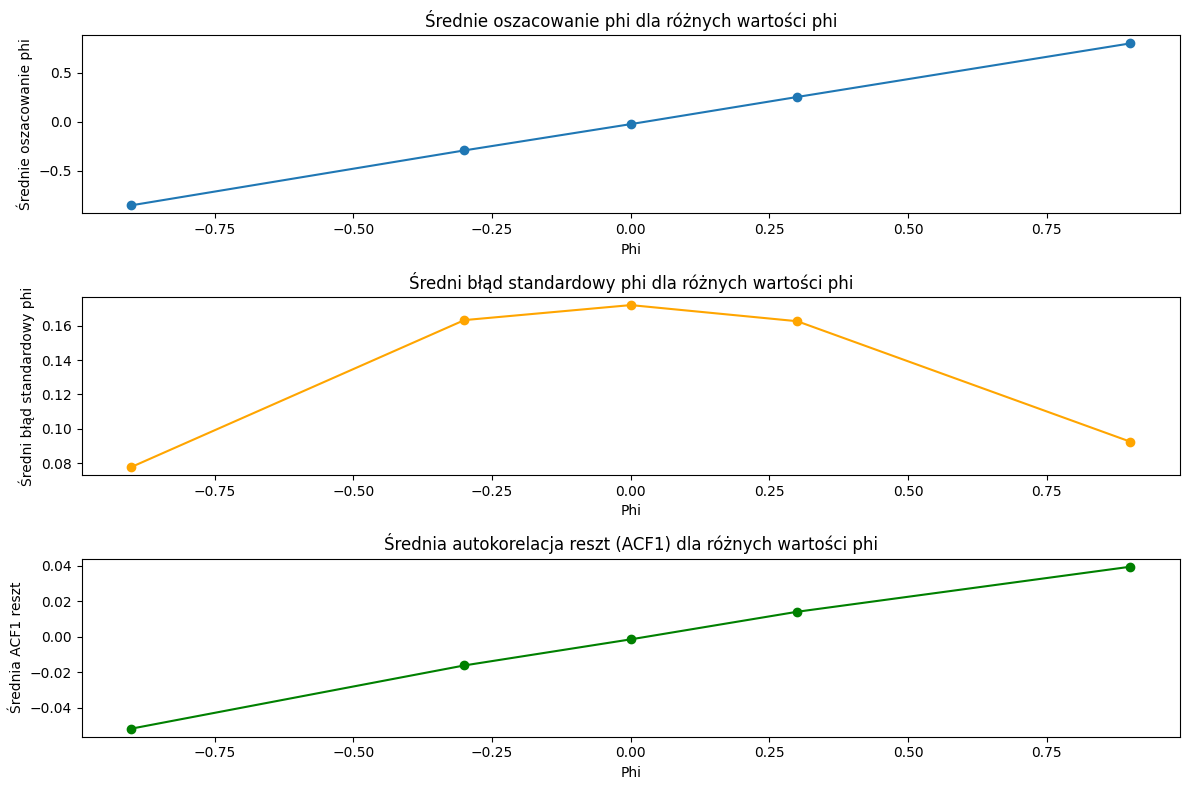

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_phi['phi'], mean_results_phi['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_phi['phi'], mean_results_phi['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_phi['phi'], mean_results_phi['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

📌 stała niska wartość N, 8 st swobody

In [ ]:
N_value = 50
df_value = 8

# Symulacja dla różnych wartości phi
results_phi = []

for sim in range(1000):
    for phi in phi_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)
        data = generate_ar1_t_errors(N_value, phi, df_value)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_phi.append({
            'phi': phi,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_phi = pd.DataFrame(results_phi)

# Obliczanie średnich wartości z symulacji dla każdej wartości phi
mean_results_phi = df_results_phi.groupby('phi', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N = 50, df = 8:")
print(mean_results_phi)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Tabela wyników, N = 50, df = 8:
   phi  estimated_phi  stderr_phi  resid_acf1
0 -0.9      -0.857118    0.075372   -0.052466
1 -0.3      -0.302650    0.154018   -0.019417
2  0.0      -0.013486    0.163575   -0.000600
3  0.3       0.245030    0.156037    0.013894
4  0.9       0.801219    0.090297    0.047629


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości phi
# Pobranie wartości oszacowań phi z symulacji
phi_values_est = df_results_phi['estimated_phi'].values
mean_phi_est = np.mean(phi_values_est)
std_phi_est = np.std(phi_values_est)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla każdej wartości phi z phi_values)
true_phi = np.mean(df_results_phi['phi'])  # średnia teoretyczna phi dla grupy phi_values
t_stat_unbiased_phi = (mean_phi_est - true_phi) / (std_phi_est / np.sqrt(len(phi_values_est)))
p_value_unbiased_phi = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_phi)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
significance_level = 0.05
reject_null_phi = np.abs((phi_values_est - true_phi) / std_phi_est) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_phi = np.mean(reject_null_phi) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):")
print(f"Średnie oszacowanie phi: {mean_phi_est}")
print(f"Odchylenie standardowe phi: {std_phi_est}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_phi}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_phi}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_phi}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_phi, ks_p_value_phi = kstest(phi_values_est, 'norm', args=(mean_phi_est, std_phi_est))

print("\nTest normalności rozkładu estymatora phi (różne phi):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_phi}")
print(f"p-value testu KS: {ks_p_value_phi}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne phi):
Średnie oszacowanie phi: -0.025400996032572287
Odchylenie standardowe phi: 0.5645345084393937
t-statystyka dla testu nieobciążoności: -3.1815976304401064
p-value dla testu nieobciążoności: 0.0014646514801517352
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 0.0%

Test normalności rozkładu estymatora phi (różne phi):
Statystyka testu Kołmogorowa-Smirnowa: 0.0825795872207091
p-value testu KS: 4.1411299984795396e-30


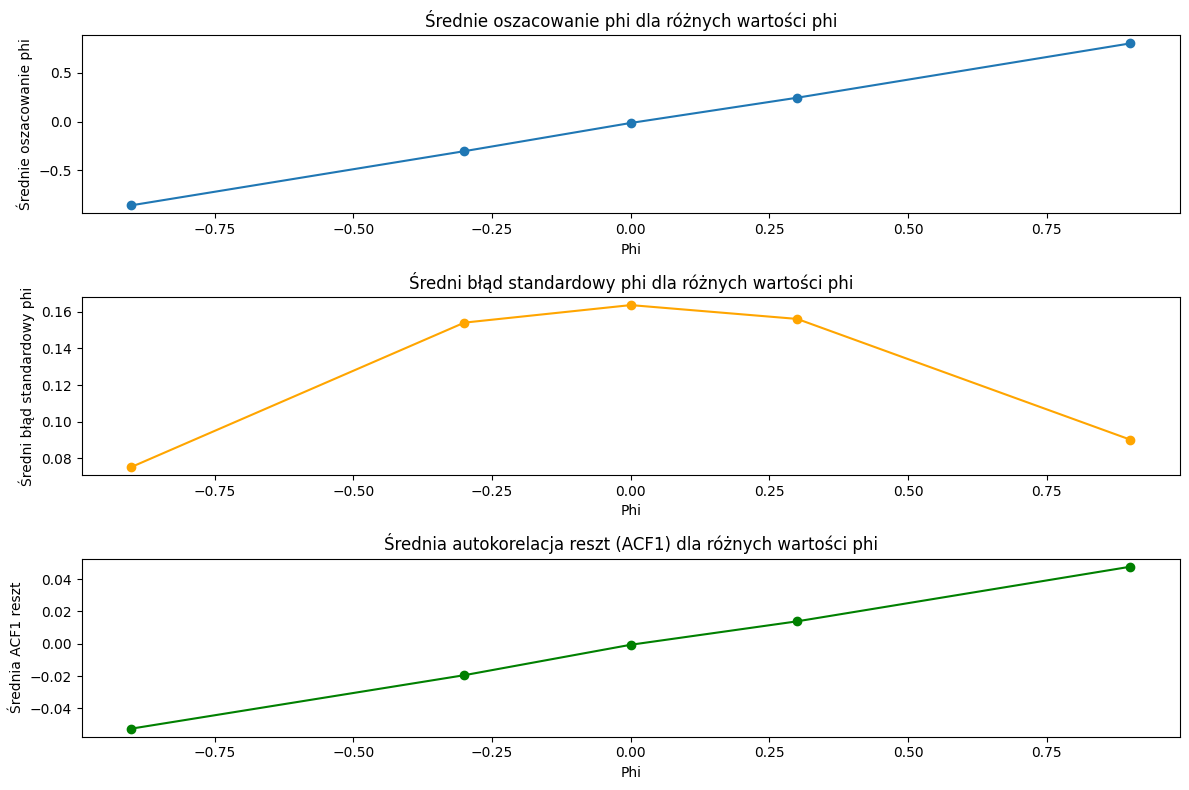

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_phi['phi'], mean_results_phi['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_phi['phi'], mean_results_phi['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_phi['phi'], mean_results_phi['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych wartości phi")
plt.xlabel("Phi")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

## 📌Analizowanie wpływu zmiany liczby stopni swobody df

### stałe wysokie N 1000, zmienne phi

📌 stała wysoka wartość N, phi 0.9



In [ ]:
N_value = 1000
phi_value = 0.9


# Symulacja dla różnych wartości stopni swobody t-Studenta
results_df = []
for sim in range(1000):
    for df in df_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)  # Użycie zmiennego ziarna losowego dla każdej symulacji
        data = generate_ar1_t_errors(N_value, phi_value, df)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_df.append({
            'df t-student': df,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_df = pd.DataFrame(results_df)

# Obliczanie średnich wartości z symulacji dla każdej wartości df t-Studenta
mean_results_df = df_results_df.groupby('df t-student', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N 1000, phi 0.9:")
print(mean_results_df)

Tabela wyników, N 1000, phi 0.9:
   df t-student  estimated_phi  stderr_phi  resid_acf1
0             3       0.896475    0.015105    0.002658
1             5       0.895075    0.014293    0.002605
2             8       0.895125    0.014165    0.002993


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości df t-Studenta
# Pobranie wartości oszacowań phi z symulacji
phi_values_est_df = df_results_df['estimated_phi'].values
mean_phi_est_df = np.mean(phi_values_est_df)
std_phi_est_df = np.std(phi_values_est_df)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla ustalonej wartości phi = 0.9)
true_phi_df = phi_value  # tutaj wartość phi jest stała (0.9)
t_stat_unbiased_df = (mean_phi_est_df - true_phi_df) / (std_phi_est_df / np.sqrt(len(phi_values_est_df)))
p_value_unbiased_df = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_df)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
reject_null_df = np.abs((phi_values_est_df - true_phi_df) / std_phi_est_df) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_df = np.mean(reject_null_df) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):")
print(f"Średnie oszacowanie phi: {mean_phi_est_df}")
print(f"Odchylenie standardowe phi: {std_phi_est_df}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_df}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_df}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_df}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_df, ks_p_value_df = kstest(phi_values_est_df, 'norm', args=(mean_phi_est_df, std_phi_est_df))

print("\nTest normalności rozkładu estymatora phi (różne df t-Studenta):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_df}")
print(f"p-value testu KS: {ks_p_value_df}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):
Średnie oszacowanie phi: 0.895558228561597
Odchylenie standardowe phi: 0.014496638258405631
t-statystyka dla testu nieobciążoności: -16.78222473879336
p-value dla testu nieobciążoności: 0.0
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 6.166666666666667%

Test normalności rozkładu estymatora phi (różne df t-Studenta):
Statystyka testu Kołmogorowa-Smirnowa: 0.030857950306187765
p-value testu KS: 0.006464077691710703


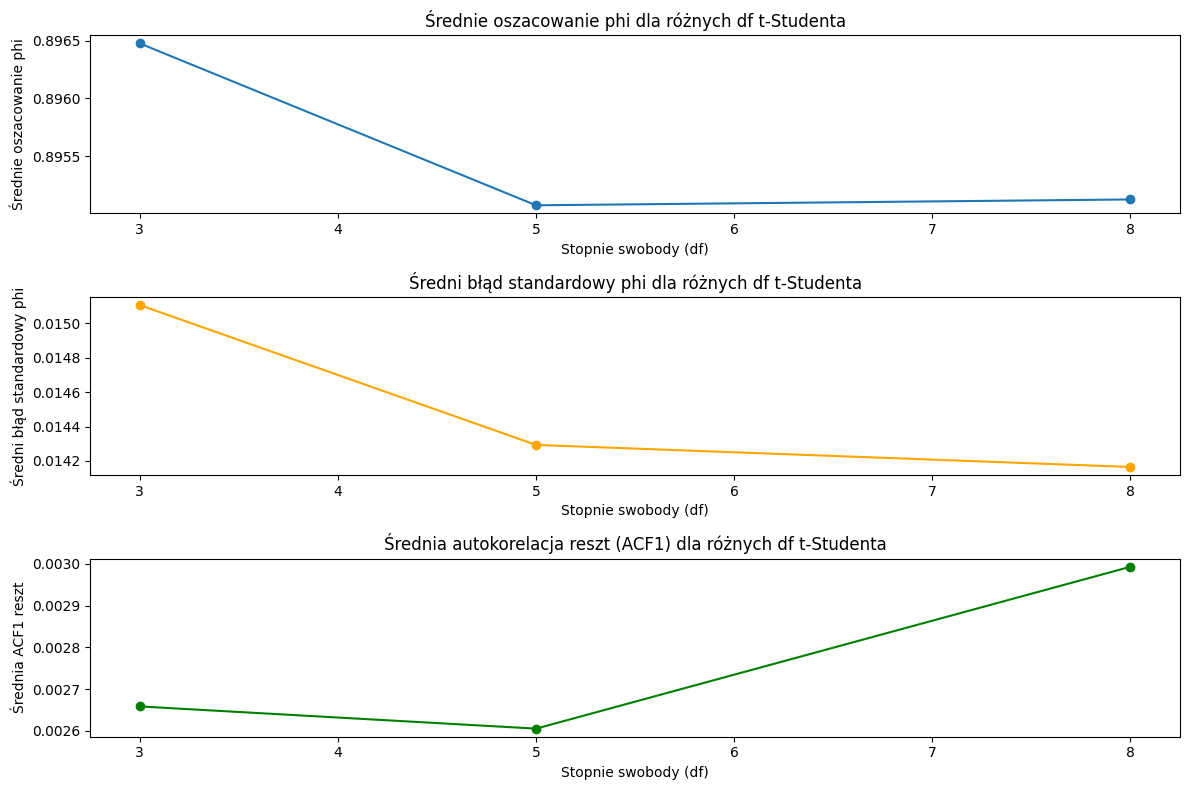

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_df['df t-student'], mean_results_df['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_df['df t-student'], mean_results_df['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_df['df t-student'], mean_results_df['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

📌 stała wysoka wartość N, phi 0

In [ ]:
N_value = 1000
phi_value = 0

# Symulacja dla różnych wartości stopni swobody t-Studenta
results_df = []
for sim in range(1000):
    for df in df_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)  # Użycie zmiennego ziarna losowego dla każdej symulacji
        data = generate_ar1_t_errors(N_value, phi_value, df)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_df.append({
            'df t-student': df,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_df = pd.DataFrame(results_df)

# Obliczanie średnich wartości z symulacji dla każdej wartości df t-Studenta
mean_results_df = df_results_df.groupby('df t-student', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N 1000, phi 0:")
print(mean_results_df)

Tabela wyników, N 1000, phi 0:
   df t-student  estimated_phi  stderr_phi  resid_acf1
0             3      -0.001279    0.035586   -0.000030
1             5      -0.002228    0.032507    0.000001
2             8      -0.000626    0.032067    0.000045


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości df t-Studenta
# Pobranie wartości oszacowań phi z symulacji
phi_values_est_df = df_results_df['estimated_phi'].values
mean_phi_est_df = np.mean(phi_values_est_df)
std_phi_est_df = np.std(phi_values_est_df)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla ustalonej wartości phi = 0.9)
true_phi_df = phi_value  # tutaj wartość phi jest stała (0.9)
t_stat_unbiased_df = (mean_phi_est_df - true_phi_df) / (std_phi_est_df / np.sqrt(len(phi_values_est_df)))
p_value_unbiased_df = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_df)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
reject_null_df = np.abs((phi_values_est_df - true_phi_df) / std_phi_est_df) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_df = np.mean(reject_null_df) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):")
print(f"Średnie oszacowanie phi: {mean_phi_est_df}")
print(f"Odchylenie standardowe phi: {std_phi_est_df}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_df}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_df}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_df}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_df, ks_p_value_df = kstest(phi_values_est_df, 'norm', args=(mean_phi_est_df, std_phi_est_df))

print("\nTest normalności rozkładu estymatora phi (różne df t-Studenta):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_df}")
print(f"p-value testu KS: {ks_p_value_df}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):
Średnie oszacowanie phi: -0.001377953244423737
Odchylenie standardowe phi: 0.031764472237638106
t-statystyka dla testu nieobciążoności: -2.376038454257756
p-value dla testu nieobciążoności: 0.017499638970920328
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 5.166666666666667%

Test normalności rozkładu estymatora phi (różne df t-Studenta):
Statystyka testu Kołmogorowa-Smirnowa: 0.011154073440078682
p-value testu KS: 0.8453002448925542


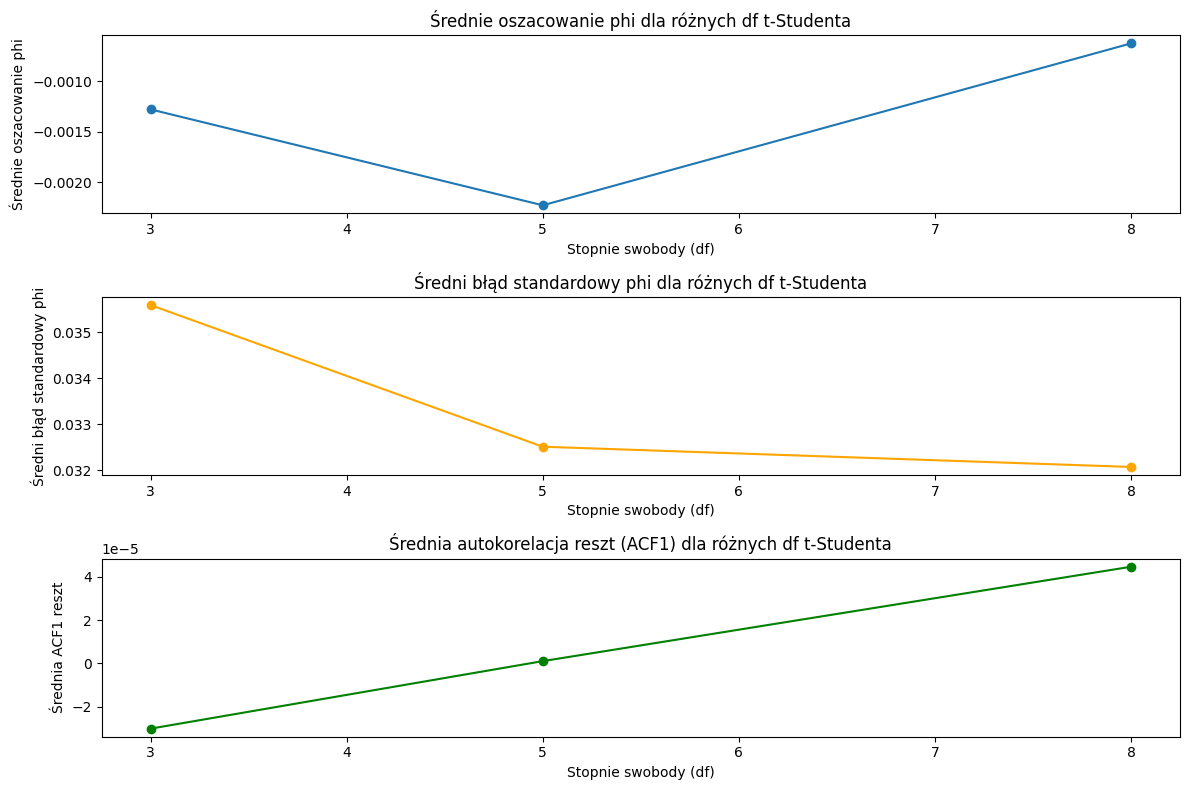

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_df['df t-student'], mean_results_df['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_df['df t-student'], mean_results_df['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_df['df t-student'], mean_results_df['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

📌 stała wysoka wartość N, phi -0.9

In [ ]:
N_value = 1000
phi_value = -0.9


# Symulacja dla różnych wartości stopni swobody t-Studenta
results_df = []
for sim in range(1000):
    for df in df_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)  # Użycie zmiennego ziarna losowego dla każdej symulacji
        data = generate_ar1_t_errors(N_value, phi_value, df)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_df.append({
            'df t-student': df,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_df = pd.DataFrame(results_df)

# Obliczanie średnich wartości z symulacji dla każdej wartości df t-Studenta
mean_results_df = df_results_df.groupby('df t-student', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N 1000, phi -0.9:")
print(mean_results_df)

Tabela wyników, N 1000, phi -0.9:
   df t-student  estimated_phi  stderr_phi  resid_acf1
0             3      -0.897441    0.015091   -0.003617
1             5      -0.897289    0.014169   -0.001717
2             8      -0.897061    0.014026   -0.002248


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości df t-Studenta
# Pobranie wartości oszacowań phi z symulacji
phi_values_est_df = df_results_df['estimated_phi'].values
mean_phi_est_df = np.mean(phi_values_est_df)
std_phi_est_df = np.std(phi_values_est_df)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla ustalonej wartości phi = 0.9)
true_phi_df = phi_value  # tutaj wartość phi jest stała (0.9)
t_stat_unbiased_df = (mean_phi_est_df - true_phi_df) / (std_phi_est_df / np.sqrt(len(phi_values_est_df)))
p_value_unbiased_df = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_df)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
reject_null_df = np.abs((phi_values_est_df - true_phi_df) / std_phi_est_df) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_df = np.mean(reject_null_df) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):")
print(f"Średnie oszacowanie phi: {mean_phi_est_df}")
print(f"Odchylenie standardowe phi: {std_phi_est_df}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_df}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_df}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_df}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_df, ks_p_value_df = kstest(phi_values_est_df, 'norm', args=(mean_phi_est_df, std_phi_est_df))

print("\nTest normalności rozkładu estymatora phi (różne df t-Studenta):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_df}")
print(f"p-value testu KS: {ks_p_value_df}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):
Średnie oszacowanie phi: -0.897263563126027
Odchylenie standardowe phi: 0.013419780392883454
t-statystyka dla testu nieobciążoności: 11.168649256427427
p-value dla testu nieobciążoności: 0.0
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 5.633333333333333%

Test normalności rozkładu estymatora phi (różne df t-Studenta):
Statystyka testu Kołmogorowa-Smirnowa: 0.029242422213598296
p-value testu KS: 0.01158941570880518


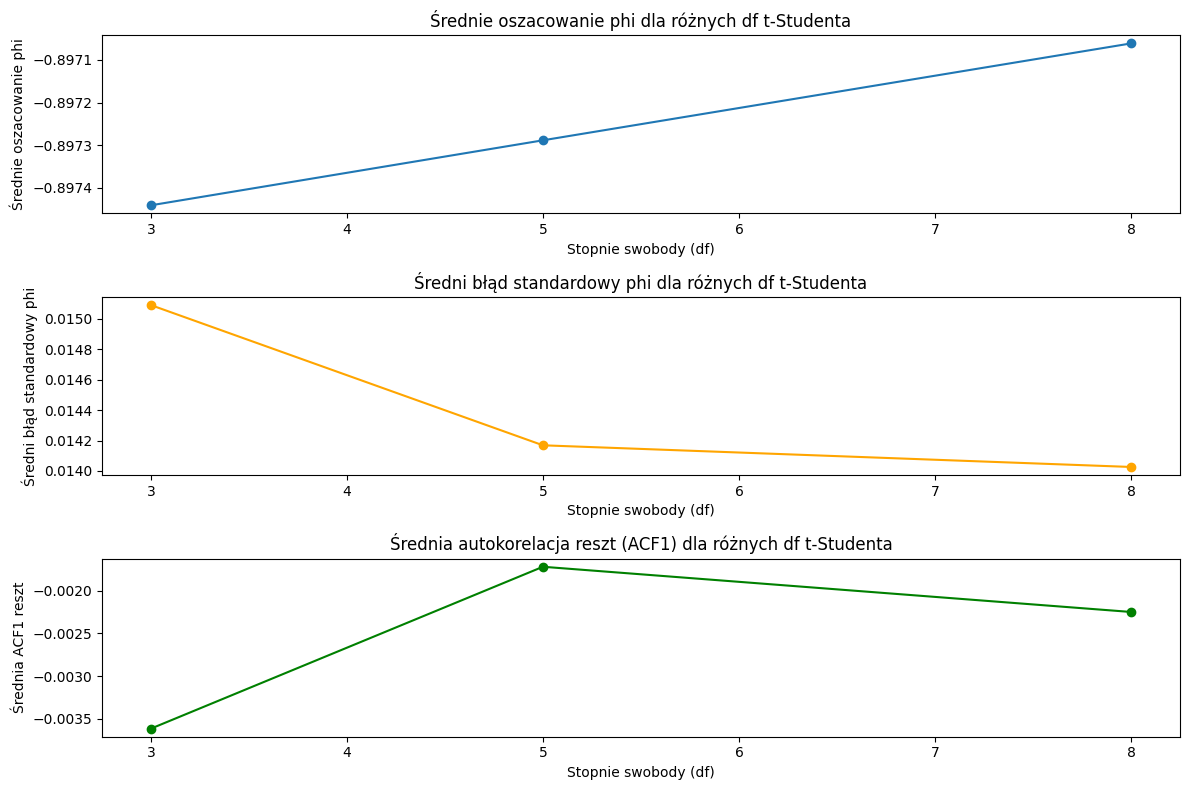

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_df['df t-student'], mean_results_df['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_df['df t-student'], mean_results_df['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_df['df t-student'], mean_results_df['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

### Stała niska wartość N 50, zmienne phi

📌 stała niska wartość N, phi 0.9

In [ ]:
N_value = 50
phi_value = 0.9


# Symulacja dla różnych wartości stopni swobody t-Studenta
results_df = []
for sim in range(1000):
    for df in df_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)  # Użycie zmiennego ziarna losowego dla każdej symulacji
        data = generate_ar1_t_errors(N_value, phi_value, df)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_df.append({
            'df t-student': df,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_df = pd.DataFrame(results_df)

# Obliczanie średnich wartości z symulacji dla każdej wartości df t-Studenta
mean_results_df = df_results_df.groupby('df t-student', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N 50, phi 0.9:")
print(mean_results_df)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Tabela wyników, N 50, phi 0.9:
   df t-student  estimated_phi  stderr_phi  resid_acf1
0             3       0.809291    0.098115    0.043401
1             5       0.809417    0.091590    0.051906
2             8       0.801797    0.090507    0.045071


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości df t-Studenta
# Pobranie wartości oszacowań phi z symulacji
phi_values_est_df = df_results_df['estimated_phi'].values
mean_phi_est_df = np.mean(phi_values_est_df)
std_phi_est_df = np.std(phi_values_est_df)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla ustalonej wartości phi = 0.9)
true_phi_df = phi_value  # tutaj wartość phi jest stała (0.9)
t_stat_unbiased_df = (mean_phi_est_df - true_phi_df) / (std_phi_est_df / np.sqrt(len(phi_values_est_df)))
p_value_unbiased_df = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_df)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
reject_null_df = np.abs((phi_values_est_df - true_phi_df) / std_phi_est_df) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_df = np.mean(reject_null_df) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):")
print(f"Średnie oszacowanie phi: {mean_phi_est_df}")
print(f"Odchylenie standardowe phi: {std_phi_est_df}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_df}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_df}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_df}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_df, ks_p_value_df = kstest(phi_values_est_df, 'norm', args=(mean_phi_est_df, std_phi_est_df))

print("\nTest normalności rozkładu estymatora phi (różne df t-Studenta):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_df}")
print(f"p-value testu KS: {ks_p_value_df}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):
Średnie oszacowanie phi: 0.8068349911892271
Odchylenie standardowe phi: 0.09066692342284842
t-statystyka dla testu nieobciążoności: -56.28135925363107
p-value dla testu nieobciążoności: 0.0
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 15.266666666666667%

Test normalności rozkładu estymatora phi (różne df t-Studenta):
Statystyka testu Kołmogorowa-Smirnowa: 0.07589305763266829
p-value testu KS: 1.7876442741669775e-15


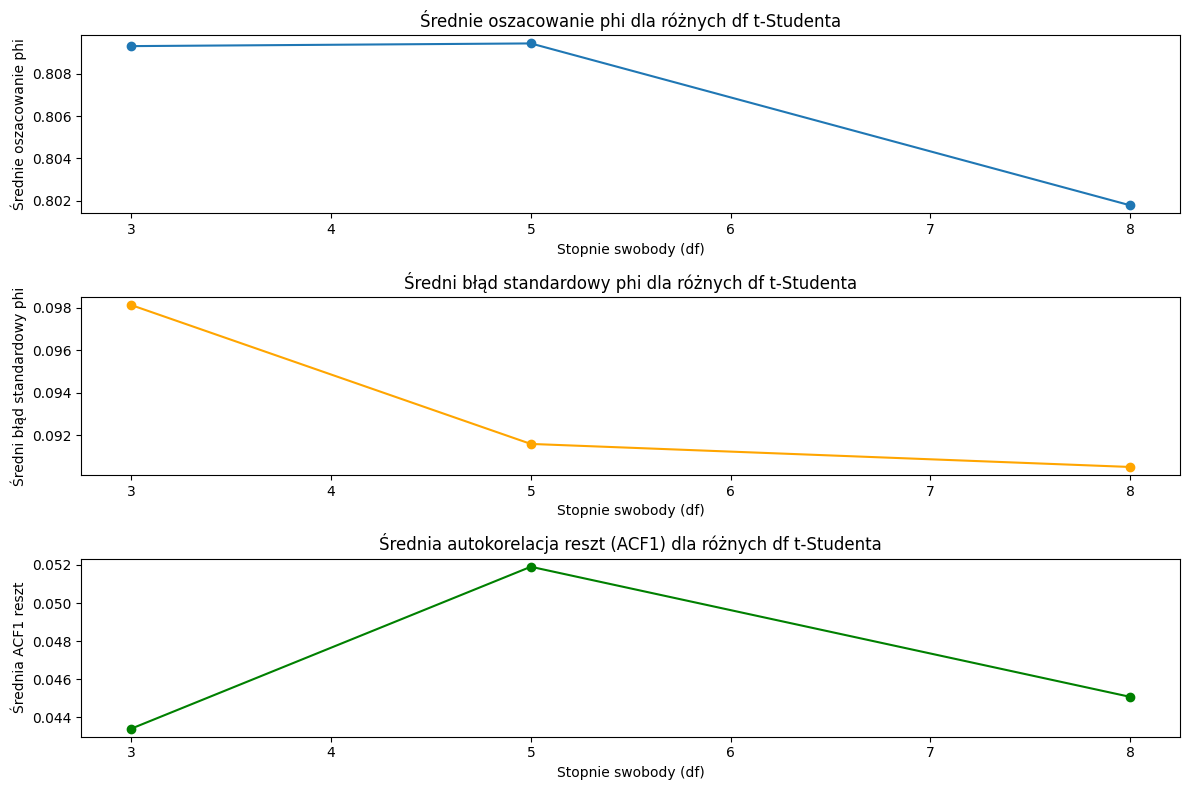

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_df['df t-student'], mean_results_df['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_df['df t-student'], mean_results_df['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_df['df t-student'], mean_results_df['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

📌 stała niska wartość N, phi 0

In [ ]:
N_value = 50
phi_value = 0


# Symulacja dla różnych wartości stopni swobody t-Studenta
results_df = []
for sim in range(1000):
    for df in df_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)  # Użycie zmiennego ziarna losowego dla każdej symulacji
        data = generate_ar1_t_errors(N_value, phi_value, df)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_df.append({
            'df t-student': df,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_df = pd.DataFrame(results_df)

# Obliczanie średnich wartości z symulacji dla każdej wartości df t-Studenta
mean_results_df = df_results_df.groupby('df t-student', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N 50, phi 0:")
print(mean_results_df)

Tabela wyników, N 50, phi 0:
   df t-student  estimated_phi  stderr_phi  resid_acf1
0             3      -0.024405    0.202707   -0.000391
1             5      -0.015683    0.174995   -0.001012
2             8      -0.008724    0.163175   -0.000642


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości df t-Studenta
# Pobranie wartości oszacowań phi z symulacji
phi_values_est_df = df_results_df['estimated_phi'].values
mean_phi_est_df = np.mean(phi_values_est_df)
std_phi_est_df = np.std(phi_values_est_df)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla ustalonej wartości phi = 0.9)
true_phi_df = phi_value  # tutaj wartość phi jest stała (0.9)
t_stat_unbiased_df = (mean_phi_est_df - true_phi_df) / (std_phi_est_df / np.sqrt(len(phi_values_est_df)))
p_value_unbiased_df = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_df)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
reject_null_df = np.abs((phi_values_est_df - true_phi_df) / std_phi_est_df) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_df = np.mean(reject_null_df) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):")
print(f"Średnie oszacowanie phi: {mean_phi_est_df}")
print(f"Odchylenie standardowe phi: {std_phi_est_df}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_df}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_df}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_df}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_df, ks_p_value_df = kstest(phi_values_est_df, 'norm', args=(mean_phi_est_df, std_phi_est_df))

print("\nTest normalności rozkładu estymatora phi (różne df t-Studenta):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_df}")
print(f"p-value testu KS: {ks_p_value_df}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):
Średnie oszacowanie phi: -0.016270577454560127
Odchylenie standardowe phi: 0.13311169038831797
t-statystyka dla testu nieobciążoności: -6.694950886357067
p-value dla testu nieobciążoności: 2.1574297903725892e-11
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 5.4%

Test normalności rozkładu estymatora phi (różne df t-Studenta):
Statystyka testu Kołmogorowa-Smirnowa: 0.013920917850397896
p-value testu KS: 0.6011470731840601


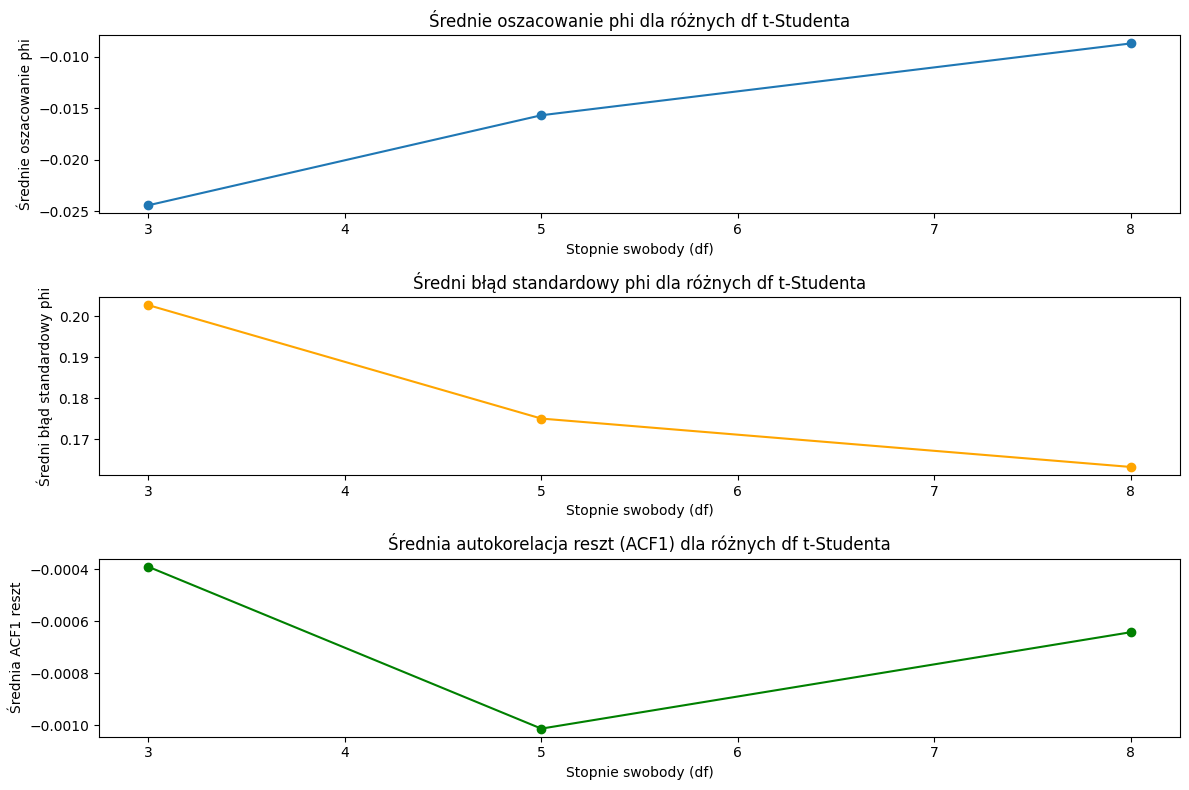

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_df['df t-student'], mean_results_df['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_df['df t-student'], mean_results_df['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_df['df t-student'], mean_results_df['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

📌 stała niska wartość N, phi -0.9

In [ ]:
N_value = 50
phi_value = -0.9


# Symulacja dla różnych wartości stopni swobody t-Studenta
results_df = []
for sim in range(1000):
    for df in df_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)  # Użycie zmiennego ziarna losowego dla każdej symulacji
        data = generate_ar1_t_errors(N_value, phi_value, df)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_df.append({
            'df t-student': df,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_df = pd.DataFrame(results_df)

# Obliczanie średnich wartości z symulacji dla każdej wartości df t-Studenta
mean_results_df = df_results_df.groupby('df t-student', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N 50, phi -0.9:")
print(mean_results_df)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

Tabela wyników, N 50, phi -0.9:
   df t-student  estimated_phi  stderr_phi  resid_acf1
0             3      -0.851664    0.085626   -0.049980
1             5      -0.854819    0.078329   -0.052825
2             8      -0.848984    0.077152   -0.049104


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości df t-Studenta
# Pobranie wartości oszacowań phi z symulacji
phi_values_est_df = df_results_df['estimated_phi'].values
mean_phi_est_df = np.mean(phi_values_est_df)
std_phi_est_df = np.std(phi_values_est_df)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla ustalonej wartości phi = 0.9)
true_phi_df = phi_value  # tutaj wartość phi jest stała (0.9)
t_stat_unbiased_df = (mean_phi_est_df - true_phi_df) / (std_phi_est_df / np.sqrt(len(phi_values_est_df)))
p_value_unbiased_df = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_df)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
reject_null_df = np.abs((phi_values_est_df - true_phi_df) / std_phi_est_df) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_df = np.mean(reject_null_df) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):")
print(f"Średnie oszacowanie phi: {mean_phi_est_df}")
print(f"Odchylenie standardowe phi: {std_phi_est_df}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_df}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_df}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_df}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_df, ks_p_value_df = kstest(phi_values_est_df, 'norm', args=(mean_phi_est_df, std_phi_est_df))

print("\nTest normalności rozkładu estymatora phi (różne df t-Studenta):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_df}")
print(f"p-value testu KS: {ks_p_value_df}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):
Średnie oszacowanie phi: -0.8518225061867795
Odchylenie standardowe phi: 0.0788037515667503
t-statystyka dla testu nieobciążoności: 33.48558869461279
p-value dla testu nieobciążoności: 0.0
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 9.766666666666666%

Test normalności rozkładu estymatora phi (różne df t-Studenta):
Statystyka testu Kołmogorowa-Smirnowa: 0.09834896769375001
p-value testu KS: 1.0364731363493275e-25


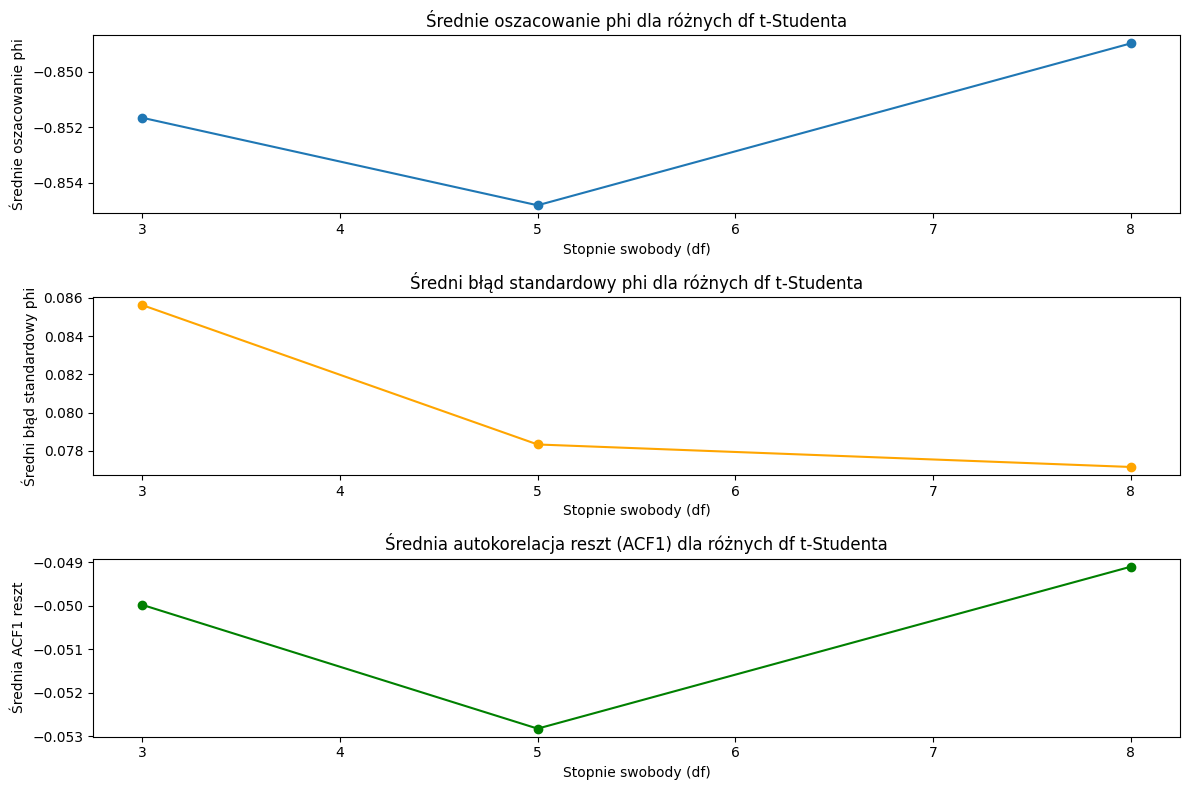

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_df['df t-student'], mean_results_df['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_df['df t-student'], mean_results_df['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_df['df t-student'], mean_results_df['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

### stałe phi 0.3, zmienne N

📌 stała wartość phi 0.3, małe N 50

In [ ]:
N_value = 50
phi_value = 0.3


# Symulacja dla różnych wartości stopni swobody t-Studenta
results_df = []
for sim in range(1000):
    for df in df_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)  # Użycie zmiennego ziarna losowego dla każdej symulacji
        data = generate_ar1_t_errors(N_value, phi_value, df)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_df.append({
            'df t-student': df,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_df = pd.DataFrame(results_df)

# Obliczanie średnich wartości z symulacji dla każdej wartości df t-Studenta
mean_results_df = df_results_df.groupby('df t-student', as_index=False).mean()

# Wyświetlenie tabeli wyników
print("Średnie wartości wyników po 1000 symulacjach, N 50, phi 0.3:")
print(mean_results_df)

Średnie wartości wyników po 1000 symulacjach, N 50, phi 0.3:
   df t-student  estimated_phi  stderr_phi  resid_acf1
0             3       0.257007    0.190362    0.015942
1             5       0.261917    0.164553    0.015326
2             8       0.263402    0.156464    0.015135


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości df t-Studenta
# Pobranie wartości oszacowań phi z symulacji
phi_values_est_df = df_results_df['estimated_phi'].values
mean_phi_est_df = np.mean(phi_values_est_df)
std_phi_est_df = np.std(phi_values_est_df)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla ustalonej wartości phi = 0.9)
true_phi_df = phi_value  # tutaj wartość phi jest stała (0.9)
t_stat_unbiased_df = (mean_phi_est_df - true_phi_df) / (std_phi_est_df / np.sqrt(len(phi_values_est_df)))
p_value_unbiased_df = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_df)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
reject_null_df = np.abs((phi_values_est_df - true_phi_df) / std_phi_est_df) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_df = np.mean(reject_null_df) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):")
print(f"Średnie oszacowanie phi: {mean_phi_est_df}")
print(f"Odchylenie standardowe phi: {std_phi_est_df}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_df}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_df}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_df}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_df, ks_p_value_df = kstest(phi_values_est_df, 'norm', args=(mean_phi_est_df, std_phi_est_df))

print("\nTest normalności rozkładu estymatora phi (różne df t-Studenta):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_df}")
print(f"p-value testu KS: {ks_p_value_df}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):
Średnie oszacowanie phi: 0.26077537619418006
Odchylenie standardowe phi: 0.13095322829098271
t-statystyka dla testu nieobciążoności: -16.40601881181809
p-value dla testu nieobciążoności: 0.0
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 6.1%

Test normalności rozkładu estymatora phi (różne df t-Studenta):
Statystyka testu Kołmogorowa-Smirnowa: 0.021194144081119026
p-value testu KS: 0.1331208548991648


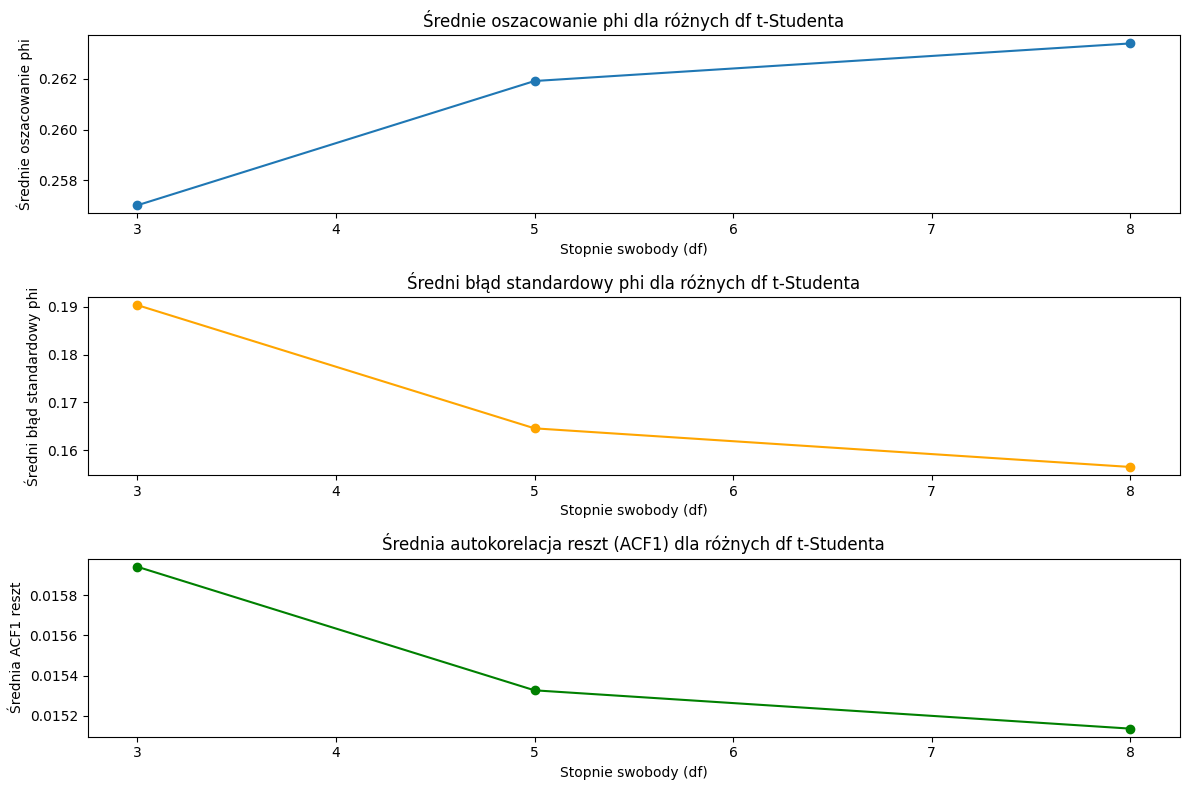

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_df['df t-student'], mean_results_df['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_df['df t-student'], mean_results_df['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_df['df t-student'], mean_results_df['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

📌 stała wartość phi 0.3, średnie N  100

In [ ]:
N_value = 100
phi_value = 0.3


# Symulacja dla różnych wartości stopni swobody t-Studenta
results_df = []
for sim in range(1000):
    for df in df_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)  # Użycie zmiennego ziarna losowego dla każdej symulacji
        data = generate_ar1_t_errors(N_value, phi_value, df)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_df.append({
            'df t-student': df,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_df = pd.DataFrame(results_df)

# Obliczanie średnich wartości z symulacji dla każdej wartości df t-Studenta
mean_results_df = df_results_df.groupby('df t-student', as_index=False).mean()

# Wyświetlenie tabeli wyników
print("Tabela wyników, N 100, phi 0.3:")
print(mean_results_df)

Tabela wyników, N 100, phi 0.3:
   df t-student  estimated_phi  stderr_phi  resid_acf1
0             3       0.271817    0.123271    0.007219
1             5       0.278348    0.108575    0.006668
2             8       0.270178    0.104588    0.008480


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości df t-Studenta
# Pobranie wartości oszacowań phi z symulacji
phi_values_est_df = df_results_df['estimated_phi'].values
mean_phi_est_df = np.mean(phi_values_est_df)
std_phi_est_df = np.std(phi_values_est_df)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla ustalonej wartości phi = 0.9)
true_phi_df = phi_value  # tutaj wartość phi jest stała (0.9)
t_stat_unbiased_df = (mean_phi_est_df - true_phi_df) / (std_phi_est_df / np.sqrt(len(phi_values_est_df)))
p_value_unbiased_df = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_df)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
reject_null_df = np.abs((phi_values_est_df - true_phi_df) / std_phi_est_df) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_df = np.mean(reject_null_df) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):")
print(f"Średnie oszacowanie phi: {mean_phi_est_df}")
print(f"Odchylenie standardowe phi: {std_phi_est_df}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_df}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_df}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_df}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_df, ks_p_value_df = kstest(phi_values_est_df, 'norm', args=(mean_phi_est_df, std_phi_est_df))

print("\nTest normalności rozkładu estymatora phi (różne df t-Studenta):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_df}")
print(f"p-value testu KS: {ks_p_value_df}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):
Średnie oszacowanie phi: 0.2734476852426185
Odchylenie standardowe phi: 0.09309556100075199
t-statystyka dla testu nieobciążoności: -15.621906770052862
p-value dla testu nieobciążoności: 0.0
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 6.1%

Test normalności rozkładu estymatora phi (różne df t-Studenta):
Statystyka testu Kołmogorowa-Smirnowa: 0.01652096670236175
p-value testu KS: 0.38188806684856513


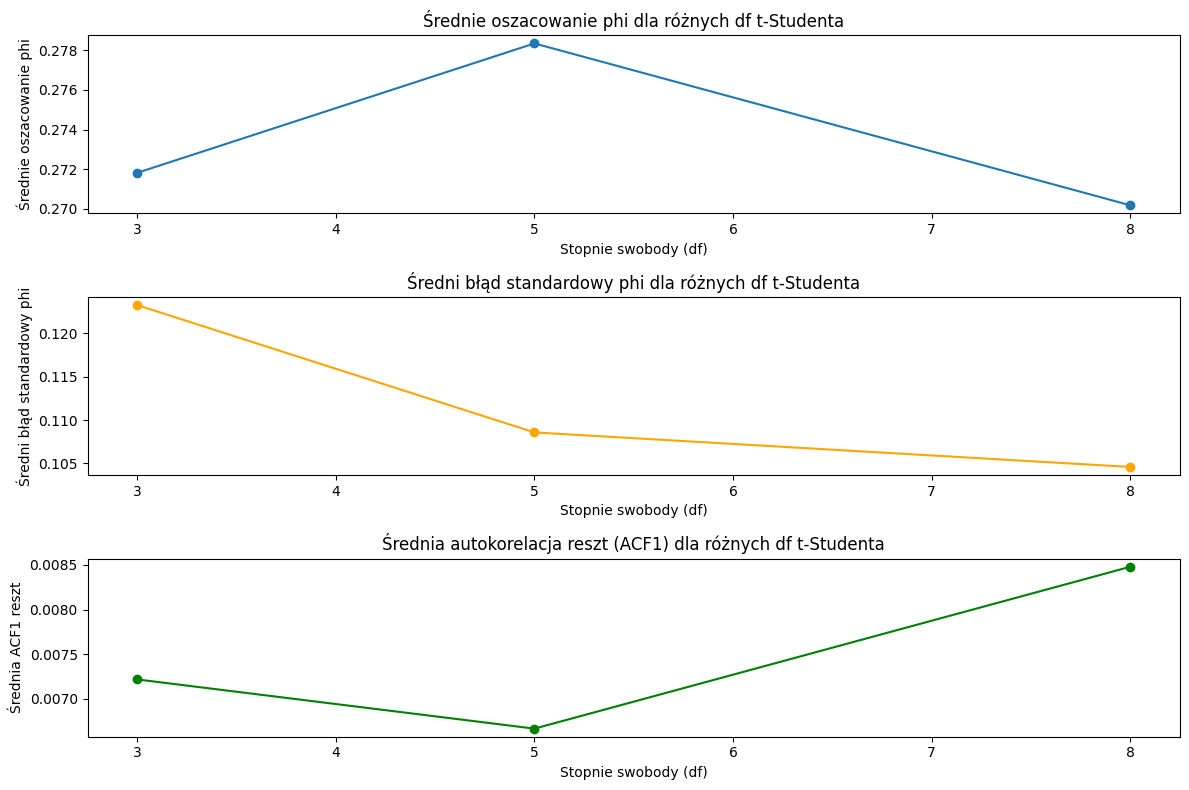

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_df['df t-student'], mean_results_df['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_df['df t-student'], mean_results_df['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_df['df t-student'], mean_results_df['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()

📌 stała wartość phi 0.3, duże N 1000

In [ ]:
N_value = 1000
phi_value = 0.3


# Symulacja dla różnych wartości stopni swobody t-Studenta
results_df = []
for sim in range(1000):
    for df in df_values:
        # Generowanie danych AR(1) ze składnikami losowymi o rozkładzie t-Studenta
        random.seed(sim)  # Użycie zmiennego ziarna losowego dla każdej symulacji
        data = generate_ar1_t_errors(N_value, phi_value, df)

        # Dopasowanie modelu AR(1)
        model = ARIMA(data, order=(1, 0, 0))
        fitted_model = model.fit()

        # Zbieranie wyników
        results_df.append({
            'df t-student': df,
            'estimated_phi': fitted_model.params[1],
            'stderr_phi': fitted_model.bse[1],
            'resid_acf1': sm.tsa.acf(fitted_model.resid, nlags=1)[1]  # pierwsza autokorelacja reszt
        })

# Konwersja wyników do DataFrame
df_results_df = pd.DataFrame(results_df)

# Obliczanie średnich wartości z symulacji dla każdej wartości df t-Studenta
mean_results_df = df_results_df.groupby('df t-student', as_index=False).mean()


# Wyświetlenie tabeli wyników
print("Tabela wyników, N 1000, phi 0.3:")
print(mean_results_df)

Tabela wyników, N 1000, phi 0.3:
   df t-student  estimated_phi  stderr_phi  resid_acf1
0             3       0.297531    0.034493    0.001147
1             5       0.297707    0.031037    0.001064
2             8       0.296602    0.030604    0.000980


In [ ]:
# Analiza rozkładu i nieobciążoności estymatora phi oraz test istotności dla różnych wartości df t-Studenta
# Pobranie wartości oszacowań phi z symulacji
phi_values_est_df = df_results_df['estimated_phi'].values
mean_phi_est_df = np.mean(phi_values_est_df)
std_phi_est_df = np.std(phi_values_est_df)

# Test nieobciążoności - H0: E(estimated_phi) = true_phi (dla ustalonej wartości phi = 0.9)
true_phi_df = phi_value  # tutaj wartość phi jest stała (0.9)
t_stat_unbiased_df = (mean_phi_est_df - true_phi_df) / (std_phi_est_df / np.sqrt(len(phi_values_est_df)))
p_value_unbiased_df = 2 * (1 - stats.norm.cdf(abs(t_stat_unbiased_df)))

# Obliczenie odsetka odrzuceń hipotezy H0: phi = true_phi na poziomie istotności 5%
reject_null_df = np.abs((phi_values_est_df - true_phi_df) / std_phi_est_df) > stats.norm.ppf(1 - significance_level / 2)
rejection_rate_df = np.mean(reject_null_df) * 100

# Analiza wyników i wyświetlenie
print("\nAnaliza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):")
print(f"Średnie oszacowanie phi: {mean_phi_est_df}")
print(f"Odchylenie standardowe phi: {std_phi_est_df}")
print(f"t-statystyka dla testu nieobciążoności: {t_stat_unbiased_df}")
print(f"p-value dla testu nieobciążoności: {p_value_unbiased_df}")
print(f"Odsetek odrzuceń hipotezy H0 na poziomie istotności {significance_level * 100}%: {rejection_rate_df}%")

# Test normalności rozkładu estymatora phi za pomocą testu Kołmogorowa-Smirnowa
ks_statistic_df, ks_p_value_df = kstest(phi_values_est_df, 'norm', args=(mean_phi_est_df, std_phi_est_df))

print("\nTest normalności rozkładu estymatora phi (różne df t-Studenta):")
print(f"Statystyka testu Kołmogorowa-Smirnowa: {ks_statistic_df}")
print(f"p-value testu KS: {ks_p_value_df}")



Analiza wpływu błędnej specyfikacji rozkładu składnika losowego na estymator phi (różne df t-Studenta):
Średnie oszacowanie phi: 0.2972800407933839
Odchylenie standardowe phi: 0.030080725944622782
t-statystyka dla testu nieobciążoności: -4.952616554866788
p-value dla testu nieobciążoności: 7.322217110417029e-07
Odsetek odrzuceń hipotezy H0 na poziomie istotności 5.0%: 4.533333333333333%

Test normalności rozkładu estymatora phi (różne df t-Studenta):
Statystyka testu Kołmogorowa-Smirnowa: 0.010928157769688307
p-value testu KS: 0.8622000606753651


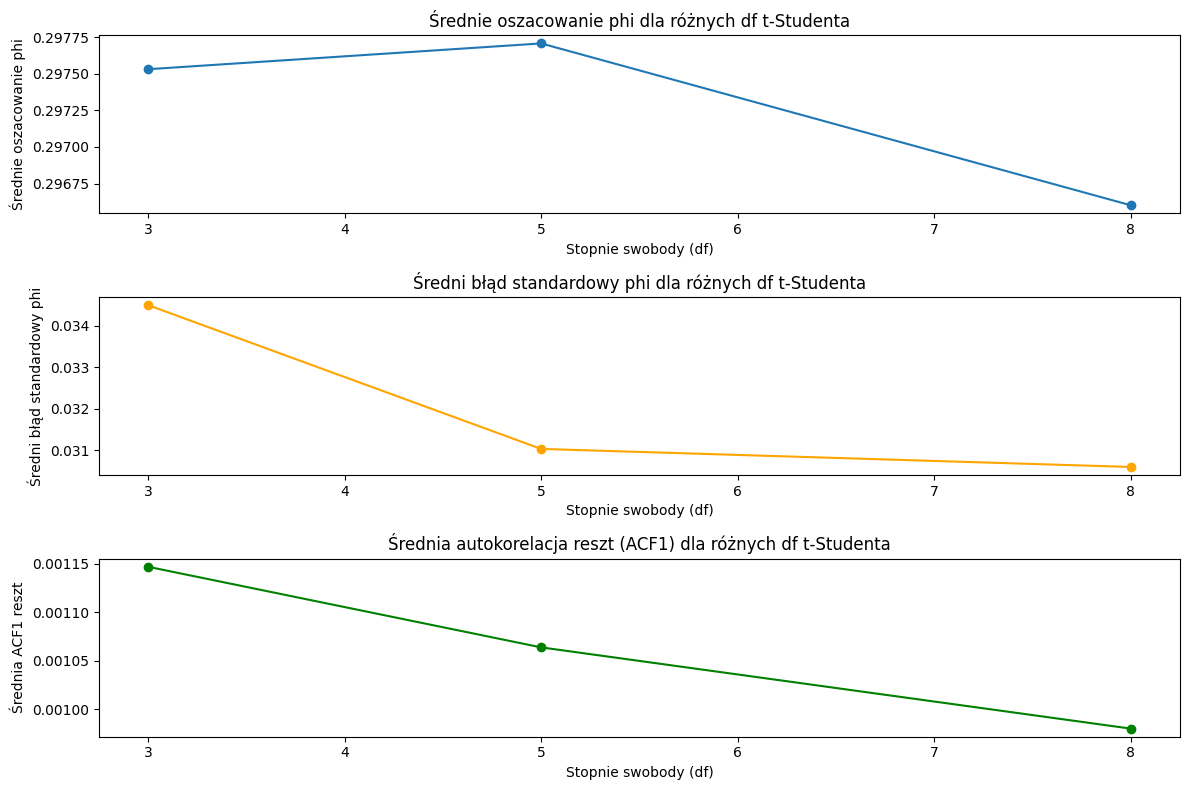

In [ ]:
# Tworzenie wykresów
plt.figure(figsize=(12, 8))

# Wykres oszacowanego phi
plt.subplot(3, 1, 1)
plt.plot(mean_results_df['df t-student'], mean_results_df['estimated_phi'], marker='o', linestyle='-')
plt.title("Średnie oszacowanie phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnie oszacowanie phi")

# Wykres błędu standardowego phi
plt.subplot(3, 1, 2)
plt.plot(mean_results_df['df t-student'], mean_results_df['stderr_phi'], marker='o', color='orange', linestyle='-')
plt.title("Średni błąd standardowy phi dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średni błąd standardowy phi")

# Wykres autokorelacji reszt (resid_acf1)
plt.subplot(3, 1, 3)
plt.plot(mean_results_df['df t-student'], mean_results_df['resid_acf1'], marker='o', color='green', linestyle='-')
plt.title("Średnia autokorelacja reszt (ACF1) dla różnych df t-Studenta")
plt.xlabel("Stopnie swobody (df)")
plt.ylabel("Średnia ACF1 reszt")

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()